# Experimental results for active learning sampling strategies

In [171]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle
import ast

import seaborn as sns

In [172]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import os
import certifi

# Set the REQUESTS_CA_BUNDLE environment variable
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

# Check the path to the CA certificates bundle
print("CA Certificates Path:", os.environ["REQUESTS_CA_BUNDLE"])

CA Certificates Path: /Users/niek/niek-env/lib/python3.11/site-packages/certifi/cacert.pem


In [5]:
!export REQUESTS_CA_BUNDLE=/etc/ssl/certs/ca-certificates.crt

In [6]:
LIBSVM_URL = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/"
LIBSVM_DOWNLOAD_FN = {
    "rcv1": "rcv1_train.binary.bz2",
    "mushrooms": "mushrooms",
    "a1a": "a1a",
    "a2a": "a2a",
    "ijcnn": "ijcnn1.tr.bz2",
    "w8a": "w8a",
}


def load_mnist(data_dir):
    dataset = MNIST(
        data_dir, train=True, transform=None, target_transform=None, download=True
    )

    X, y = dataset.data.numpy(), dataset.targets.numpy()
    X = X / 255.0
    X = X.reshape((X.shape[0], -1))
    return X, y


def load_libsvm(name, data_dir):
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)

    fn = LIBSVM_DOWNLOAD_FN[name]
    data_path = os.path.join(data_dir, fn)

    if not os.path.exists(data_path):
        url = urllib.parse.urljoin(LIBSVM_URL, fn)
        print("Downloading from %s" % url)

        import ssl

        ssl._create_default_https_context = ssl._create_unverified_context

        urllib.request.urlretrieve(url, data_path)
        print("Download complete.")

    X, y = load_svmlight_file(data_path)
    return X, y

In [7]:
from torch.utils.data import Dataset

def get_dataset(dataset_name, split, datadir, exp_dict):
    train_flag = True if split == 'train' else False
    if dataset_name in ['B', 'C']:
        bias = 1;
        scaling = 10;
        sparsity = 10;
        solutionSparsity = 0.1;
        n = 1000

        if dataset_name == 'C':
            p = 100
        if dataset_name == 'B':
            p = 10000

        A = np.random.randn(n,p)+bias;
        A = A.dot(np.diag(scaling* np.random.randn(p)))
        A = A * (np.random.rand(n,p) < (sparsity*np.log(n)/n));
        w = np.random.randn(p) * (np.random.rand(p) < solutionSparsity);

        b = np.sign(A.dot(w));
        b = b * np.sign(np.random.rand(n)-0.1);
        labels = np.unique(b)
        A = A / np.linalg.norm(A, axis=1)[:, None].clip(min=1e-6)
        A = A * 2
        b[b==labels[0]] = 0
        b[b==labels[1]] = 1

        dataset = torch.utils.data.TensorDataset(torch.FloatTensor(A), torch.FloatTensor(b))

        return DatasetWrapper(dataset, split=split)

    if dataset_name == 'tiny_imagenet':
        if train_flag:
            transform_train = transforms.Compose([
                # transforms.Resize(32),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            # define dataloader
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                        transform=transform_train)

        else:
            transform_test = transforms.Compose([
                # transforms.Resize(32),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                       transform=transform_test)

    if dataset_name == 'imagenette2-160':
        if train_flag:
            transform_train = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                # transforms.RandomResizedCrop(224),
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            # define dataloader
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                        transform=transform_train)

        else:
            transform_test = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                       transform=transform_test)

    if dataset_name == 'imagewoof2-160':
        if train_flag:
            transform_train = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                # transforms.RandomResizedCrop(224),
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            # define dataloader
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                        transform=transform_train)

        else:
            transform_test = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                       transform=transform_test)

    if dataset_name == "mnist":
        view = torchvision.transforms.Lambda(lambda x: x.view(-1).view(784))
        dataset = torchvision.datasets.MNIST(datadir, train=train_flag,
                               download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.5,), (0.5,)),
                                   view
                               ])
                               )

    if dataset_name == "cifar10":
        transform_function = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        dataset = torchvision.datasets.CIFAR10(
            root=datadir,
            train=train_flag,
            download=True,
            transform=transform_function)

    if dataset_name == "cifar100":
        transform_function = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        dataset = torchvision.datasets.CIFAR100(
            root=datadir,
            train=train_flag,
            download=True,
            transform=transform_function)

    if dataset_name in ['B', 'C']:
        bias = 1;
        scaling = 10;
        sparsity = 10;
        solutionSparsity = 0.1;
        n = 1000

        if dataset_name == 'C':
            p = 100
        if dataset_name == 'B':
            p = 10000

        A = np.random.randn(n,p)+bias;
        A = A.dot(np.diag(scaling* np.random.randn(p)))
        A = A * (np.random.rand(n,p) < (sparsity*np.log(n)/n));
        w = np.random.randn(p) * (np.random.rand(p) < solutionSparsity);

        b = np.sign(A.dot(w));
        b = b * np.sign(np.random.rand(n)-0.1);
        labels = np.unique(b)
        A = A / np.linalg.norm(A, axis=1)[:, None].clip(min=1e-6)
        A = A * 2
        b[b==labels[0]] = 0
        b[b==labels[1]] = 1
        # squared_max, squared_min = compute_max_eta_squared_loss(A)
        # logistic_max, logistic_min = compute_max_eta_logistic_loss(A)
        dataset = torch.utils.data.TensorDataset(torch.FloatTensor(A), torch.FloatTensor(b))

        return DatasetWrapper(dataset, split=split)


    if dataset_name in ["mushrooms", "w8a",
                        "rcv1", "ijcnn", 'a1a','a2a',
                        "mushrooms_convex", "w8a_convex",
                        "rcv1_convex", "ijcnn_convex", 'a1a_convex'
                        , 'a2a_convex']:

        sigma_dict = {"mushrooms": 0.5,
                      "w8a":20.0,
                      "rcv1":0.25 ,
                      "ijcnn":0.05}

        X, y = load_libsvm(dataset_name.replace('_convex', ''),
                           data_dir=datadir)

        labels = np.unique(y)

        y[y==labels[0]] = 0
        y[y==labels[1]] = 1
        # splits used in experiments
        splits = train_test_split(X, y, test_size=0.2, shuffle=True,
                    random_state=9513451)
        X_train, X_test, Y_train, Y_test = splits

        if "_convex" in dataset_name:
            if train_flag:
                # training set
                X_train = torch.FloatTensor(X_train.toarray())
                Y_train = torch.FloatTensor(Y_train)
                dataset = torch.utils.data.TensorDataset(X_train, Y_train)
            else:
                # test set
                X_test = torch.FloatTensor(X_test.toarray())
                Y_test = torch.FloatTensor(Y_test)
                dataset = torch.utils.data.TensorDataset(X_test, Y_test)

            return DatasetWrapper(dataset, split=split)

        if train_flag:
            # fname_rbf = "%s/rbf_%s_%s_train.pkl" % (datadir, dataset_name, sigma_dict[dataset_name])
            fname_rbf = "%s/rbf_%s_%s_train.npy" % (datadir, dataset_name, sigma_dict[dataset_name])
            if os.path.exists(fname_rbf):
                k_train_X = np.load(fname_rbf)
            else:
                k_train_X = rbf_kernel(X_train, X_train, sigma_dict[dataset_name])
                np.save(fname_rbf, k_train_X)
                print('%s saved' % fname_rbf)

            X_train = k_train_X
            X_train = torch.FloatTensor(X_train)
            Y_train = torch.LongTensor(Y_train)

            dataset = torch.utils.data.TensorDataset(X_train, Y_train)

        else:
            fname_rbf = "%s/rbf_%s_%s_test.npy" % (datadir, dataset_name, sigma_dict[dataset_name])
            if os.path.exists(fname_rbf):
                k_test_X = np.load(fname_rbf)
            else:
                k_test_X = rbf_kernel(X_test, X_train, sigma_dict[dataset_name])
                np.save(fname_rbf, k_test_X)
                print('%s saved' % fname_rbf)

            X_test = k_test_X
            X_test = torch.FloatTensor(X_test)
            Y_test = torch.LongTensor(Y_test)

            dataset = torch.utils.data.TensorDataset(X_test, Y_test)

    if dataset_name == "synthetic":
        margin = exp_dict["margin"]

        X, y, _, _ = make_binary_linear(n=exp_dict["n_samples"],
                                        d=exp_dict["d"],
                                        margin=margin,
                                        y01=True,
                                        bias=True,
                                        separable=exp_dict.get("separable", True),
                                        seed=42)
        # No shuffling to keep the support vectors inside the training set
        splits = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
        X_train, X_test, Y_train, Y_test = splits

        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)

        Y_train = torch.LongTensor(Y_train)
        Y_test = torch.LongTensor(Y_test)

        if train_flag:
            dataset = torch.utils.data.TensorDataset(X_train, Y_train)
        else:
            dataset = torch.utils.data.TensorDataset(X_test, Y_test)

    if dataset_name == "matrix_fac":
        fname = datadir + 'matrix_fac.pkl'
        if not os.path.exists(fname):
            data = generate_synthetic_matrix_factorization_data()
            ut.save_pkl(fname, data)

        A, y = ut.load_pkl(fname)

        X_train, X_test, y_train, y_test = train_test_split(A, y, test_size=0.2, random_state=9513451)

        training_set = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
        test_set = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))

        if train_flag:
            dataset = training_set
        else:
            dataset = test_set

    return DatasetWrapper(dataset, split=split)

class DatasetWrapper:
    def __init__(self, dataset, split):
        self.dataset = dataset
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data, target = self.dataset[index]


        return {"images":data,
                'labels':target,
                'meta':{'indices':index}}

class NlpDatasetWrapper(Dataset):
    def __init__(self, corpus, data, bptt):
        self.corpus = corpus
        self.data = data
        self.bptt = bptt

    def __len__(self):
        return self.data.size(0) // self.bptt

    def __getitem__(self, index):
        data, targets = nlp_utils.get_batch(self.data, index*self.bptt, self.bptt)

        return {"images":data,
                'labels':targets,
                'meta':{'indices':index}}

def rbf_kernel(A, B, sigma):
    # func = torch.nn.PairwiseDistance(p=2.0, eps=1e-06, keepdim=True)
    # result = func(torch.from_numpy(A.toarray())[None], torch.from_numpy(B.toarray())[None])

    # np.square(metrics.pairwise.pairwise_distances(A.toarray(), B.toarray(), metric="euclidean"))


    # numpy version
    distsq = np.square(metrics.pairwise.pairwise_distances(A, B, metric="euclidean"))
    K = np.exp(-1 * distsq/(2*sigma**2))
    return K

In [8]:
import os
import urllib
import torch

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn import metrics

data = get_dataset("mushrooms", split="train", datadir="~", exp_dict={})
y = np.array([data[i]["labels"].numpy() for i in range(len(data))])
X = np.array([data[i]["images"].numpy() for i in range(len(data))])

data = get_dataset("mushrooms", split="test", datadir="~", exp_dict={})
ytest = np.array([data[i]["labels"].numpy() for i in range(len(data))])
Xtest = np.array([data[i]["images"].numpy() for i in range(len(data))])

In [9]:
X.shape

(6499, 6499)

In [10]:
y.shape

(6499,)

In [164]:
with open('mushroom_train.pkl', 'wb') as f:
    pickle.dump(
        get_dataset("mushrooms", split="train", datadir="~", exp_dict={}),
        f
    )

In [165]:
with open('mushroom_test.pkl', 'wb') as f:
    pickle.dump(
        get_dataset("mushrooms", split="test", datadir="~", exp_dict={}),
        f
    )

# Specify learning algorithms

In [11]:
import math


def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    y = sigmoid(y)
    return y


def forward_squared_hinge(X, theta):
    fwd = np.matmul(X, theta)
    return fwd


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def grad_squared_hinge(x, y, theta):
    sy = 2 * y - 1
    grad = -np.max(1 - sy * np.dot(x, theta), 0) * sy * x
    return grad


def cross_entropy(p, y, epsilon=1e-15):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    return l


def squared_hinge_loss(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    u = p * sy.T
    l = (1 / 2) * np.sum(np.maximum(1 - u, 0) ** 2)
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def accuracy_sign(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def sampling(x, a=1):
    return 1


sampling_exp = 0.1


def exp_sampling(x):
    sp = 0
    if x < 1:
        sp = 1 - math.exp(sampling_exp * (x - 1))
    return sp


mu = 1


def uncertainty_sampling(x):
    sp = min(1 / (1 + mu * abs(x)), 1)
    return sp


beta = 1


def squared_hinge_loss_sampling(x):
    x = x[0]
    sp = 0
    if x < 1:
        sp = (beta / 2) * (1 - (cmargin - 1) / (cmargin - x))
    return sp


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    #  if np.linalg.norm(theta) > 1:
    #    theta = theta / np.linalg.norm(theta)
    return newtheta

In [160]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

# CHANGE 4: Moved kappa, kappa0, polyakexp, omega to argument
def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=2,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
):
    #phi = 2 * np.pi * np.random.rand()
    # theta = np.array([np.cos(phi), np.sin(phi)])
    # theta = np.array([theta_star[0], -theta_star[1]])
    # CHANGE 1: random initialisation is now of shape X.shape[1]
    theta = np.random.rand(X.shape[1])
    stheta = theta

    n_iterations = X.shape[0]  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # CHANGE 2: we loop over the data set size (X.shape[0]) rather than npoints
    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        #thetas[i] = theta
        if mode == "rand":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "opt":
            raise ValueError(
                "Can't run opt-mode because on real datasets we do not know theta_star!"
            )
            w = 10 * theta_star
            p = forward(xx, theta)
            q = forward(xx, w)
            pz = p * (1 - q) + (1 - p) * q
            grad = backward(xx, yy, p)
        elif mode == "uncertainty":
            w = theta
            p = forward(xx, theta)
            q = forward(xx, w)
            pz = p * (1 - q) + (1 - p) * q
            grad = backward(xx, yy, p)
        elif mode == "squared_hinge":
            p = np.dot(xx, theta)
            pz = sampling((2 * yy - 1) * p)
            grad = grad_squared_hinge(xx, yy, theta)
        elif mode == "polyak":
            p = np.dot(xx, theta)
            grad = grad_squared_hinge(xx, yy, theta)
            #        zeta = min(kappa * loss(p, yy) / (np.linalg.norm(grad)**2), kappa0)
            zeta = min(
                kappa * 1 / (2 * np.linalg.norm(xx) ** 2), kappa0
            )  # squared hinge loss function
            if (2 * yy - 1) * p > 1:
                zeta = 0
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak-becpi":  # binary cross entropy pi sampling
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak-bec-absloss":  # binary cross entropy
            # Hyperparameter tune for different values of polyakexp (including 0), compare to random
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak-rand":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)

            gradient = backward(xx, yy, p)
            theta = update(theta, zeta * gradient)
        elif mode == "bec-absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = np.clip(prob_const * pz, a_min=0, a_max=1)
            grad = backward(xx, yy, p)
        elif mode == "bec-minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "bec-minx1_default_alpha_x0":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([bec, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-bec-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        z = np.random.binomial(1, pz)
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        losses_test[i] = loss(p, ytest)
        losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 100 == 0:
            print("loss:", losses_test[i], "theta:", theta)

    # CHANGE 3: We write all results to a dict for easier access
    return {
        "losses": losses.tolist(),
        "losses_reg": losses_reg.tolist(),
        "losses_test": losses_test.tolist(),
        "losses_test_reg": losses_test_reg.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        #"samples": samples.tolist(),
        #"thetas": thetas.tolist(),
    }

# Evaluation



## Run hyperparameter search
Since we do not want to touch the test set that we will use to create our plots (to avoid overfitting on the test set), we split the train set into a train and val set.

In [16]:
trials = {}
best_knowns = {}

In [17]:
from sklearn.model_selection import KFold

In [168]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import csv
import functools

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
csv_file = os.path.join(notebook_dir, "hyperparam_results_run_optimised_constant_pz_weighted_mean_loss_cv_unregloss.csv")

search_spaces = {
    #"uncertainty": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #},
    #"squared_hinge": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #},
    #"polyak": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #    'kappa': hp.uniform('kappa', 0.5, 3),
    #    'kappa0': hp.loguniform('kappa0', -3, -0.5),
    #},
    
    #"bec-absloss": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #},
    #"rand": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
        # pz0=0.5 yields E[pz] = 0.5
    #    'pz0': 0.5
    #},
    #"polyak-bec-absloss": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #    'kappa': hp.uniform('kappa', 1, 2),
    #    'kappa0': hp.loguniform('kappa0', -3, -0.1),
        # Derived by hand analytically that 0.272 yields E[pz] = 0.5
    #    'polyakexp': hp.uniform('polyakexp', 0, 2)
    #},
    "polyak-becpi": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.uniform('lam', 0, 3),
        'kappa': hp.uniform('kappa', 1, 2),
        'kappa0': hp.loguniform('kappa0', -3, -0.1),
        'omega': hp.loguniform('omega', -.001, 0.001),
    }
    ,
    #"polyak-rand": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #    'kappa': hp.uniform('kappa', 0.5, 3),
    #    'kappa0': hp.loguniform('kappa0', -3, -0.5),
        # Under bec-absloss, E[pz] = 0.5
        # Under polyak-bec-absloss, E[pz] = 0.5 for polyakexp 0.272
        # Under rand with pz0=0.5, E[pz] = 0.5
        # Hence, under polyak-rand with pz=0.5, E[pz] = 0.5 should also be 0.272 under pz0=0.5 
    #    'pz0': 0.5,
    #    'polyakexp': 0.272
    #},
    #"polyak-becpi": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #    'kappa': hp.uniform('kappa', 0.5, 3),
    #    'kappa0': hp.loguniform('kappa0', -3, -0.5),
    #},

} 

# Create a Trials object to store optimization results
def create_trial(row):
    # Extract hyperparameter values
    hyperparameters = {param: row[param] for param in param_columns}
    
    # Define the trial dictionary
    trial = {
        'result': {
            'loss': row[loss_column],
            'status': STATUS_OK,
        },
        'misc': {
            'vals': hyperparameters,
            'idxs': {param: [0] for param in param_columns},
        },
    }
    
    return trial

for method in search_spaces:
    if method not in trials:
        trials[method] = Trials()
    if method not in best_knowns:
        best_loss = float('inf')
        best_knowns[method] = {
            "best_loss": best_loss,
            "best_params": None
        }
    """
    existing_runs = hyperparam_results[hyperparam_results.algorithm == method].reset_index()
    print(f"Prepopulating {method}")
    
    for idx, row in existing_runs.iterrows():
        # Extract hyperparameters from the dictionary column
        hyperparameters = eval(row.hyperparams)

        # Define the trial dictionary
        trial = {
            'tid': idx, 
            'state': STATUS_OK,
            'result': {
                'loss': row.loss,
                'status': STATUS_OK,
            },
            'misc': {
                'vals': hyperparameters,
                'idxs': {param: [0] for param in hyperparameters.keys()},
                'cmd': None,
                'tid': idx,
            },
            'spec': None,
            'owner': None,
            'book_time': None,
            'refresh_time': None,
            'exp_key': None,
        }

        print(f"Adding trial {trial}")
        # Add the trial to the Trials object
        trials[method].insert_trial_doc(trial)
        if row.loss < best_loss:
            best_loss = row.loss
        """

# Define the original function with all arguments
def train_and_get_last_loss(X, y, mode, params, num_folds = 3):
    kf = KFold(n_splits=num_folds)
    
    total_loss = 0
    total_p_loss = 0
    for train_index, test_index in kf.split(X):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]
        d = train_model(X_train, y_train, X_val, y_val, mode=mode, verbose=False, **params)

        w = [(i+1) / len(d["losses_test"]) for i in range(len(d["losses_test"]))]
        w_array = np.array(w)
        losses_test_array = np.array(d["losses_test"])
        current_loss = np.mean(w_array * losses_test_array)
        
        total_loss += current_loss
        total_p_loss += 25 * (np.mean(d['probs']) - 0.5) ** 2

    mean_loss = total_loss / num_folds
    mean_p_loss = total_p_loss / num_folds
    combined_loss = mean_loss + mean_p_loss

    if combined_loss < best_knowns[method]["best_loss"]:
        best_knowns[method]["best_loss"] = combined_loss
        best_knowns[method]["best_params"] = params
        print(f"New best parameters: {best_knowns[method]['best_params']} with loss {mean_loss} and probability MSE {mean_p_loss / 25}")

    with open(csv_file, 'a', newline='') as file:
        writer = csv.writer(file, delimiter='\t')

        if not os.path.exists(csv_file):
            writer.writerow(['Method', 'Combined Loss', 'Loss', 'Pz Loss', 'Best Params'])  # Write header if file doesn't exist

        writer.writerow([method, combined_loss, mean_loss, mean_p_loss, params])

    return combined_loss

# Fix some arguments using functools.partial

for method in search_spaces:
    print(f"Tuning for {method}")
    get_loss_after_training = functools.partial(
        train_and_get_last_loss,
        X, y, method
    )

    # Perform hyperparameter optimization using Hyperopt
    best = fmin(
        fn=get_loss_after_training,
        space=search_spaces[method],
        algo=tpe.suggest,
        max_evals=140,
        trials=trials[method],
    )
    print(f"Finished tuning for {method}")
    print()


Tuning for polyak-becpi
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [1:10:37<00:00, 423.75s/trial, best loss: 0.3466167220358079]
Finished tuning for polyak-becpi



## Use best hyperparams to construct plot
Now that we found the best hyperparameters, we compare the test set performance of each learning algorithm when training on the full train set (train + val).

In [59]:
hyperparam_results = pd.read_csv("hyperparam_results_run_optimised_constant_pz_weighted_mean_loss_cv_unregloss.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "model_loss", "pz_loss", "hyperparams"]

In [60]:
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()

In [61]:
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

In [62]:
import ast

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [63]:
hyperparam_per_algo

{'bec-absloss': {'eta': 0.057310790306545845, 'lam': 0.3097914232869957},
 'polyak-bec-absloss': {'eta': 0.0661921798883039,
  'kappa': 1.0027496041467079,
  'kappa0': 0.15015615130287707,
  'lam': 1.8033101420933129,
  'polyakexp': 0.3636956280746284},
 'polyak-rand': {'eta': 0.3450177368753892,
  'kappa': 2.569651666733532,
  'kappa0': 0.09617954658211961,
  'lam': 0.19942238238898957,
  'polyakexp': 0.272,
  'pz0': 0.5},
 'rand': {'eta': 0.06643063763463221, 'lam': 0.25316837000465253, 'pz0': 0.5}}

In [34]:
hyperparam_per_algo

{'bec-absloss': {'eta': 0.057310790306545845, 'lam': 0.3097914232869957},
 'polyak-bec-absloss': {'eta': 0.0661921798883039,
  'kappa': 1.0027496041467079,
  'kappa0': 0.15015615130287707,
  'lam': 1.8033101420933129,
  'polyakexp': 0.3636956280746284},
 'polyak-rand': {'eta': 0.3450177368753892,
  'kappa': 2.569651666733532,
  'kappa0': 0.09617954658211961,
  'lam': 0.19942238238898957,
  'polyakexp': 0.272,
  'pz0': 0.5},
 'rand': {'eta': 0.06643063763463221, 'lam': 0.25316837000465253, 'pz0': 0.5}}

In [35]:
hyperparam_per_algo

{'bec-absloss': {'eta': 0.057310790306545845, 'lam': 0.3097914232869957},
 'polyak-bec-absloss': {'eta': 0.0661921798883039,
  'kappa': 1.0027496041467079,
  'kappa0': 0.15015615130287707,
  'lam': 1.8033101420933129,
  'polyakexp': 0.3636956280746284},
 'polyak-rand': {'eta': 0.3450177368753892,
  'kappa': 2.569651666733532,
  'kappa0': 0.09617954658211961,
  'lam': 0.19942238238898957,
  'polyakexp': 0.272,
  'pz0': 0.5},
 'rand': {'eta': 0.06643063763463221, 'lam': 0.25316837000465253, 'pz0': 0.5}}

In [36]:
polyak_exps = list(range(10))
polyak_strs = [f"0.{elem}" for elem in polyak_exps]
polyak_exps = [eval(elem) for elem in polyak_strs]
polyak_exps

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

## Bec-absloss with Polyak

In [38]:
# Run this cell only if ~/workspace/milan_paper/polyak_becs_uniform.csv doesn't yet exist
polyak_bec_params = hyperparam_per_algo["polyak-bec-absloss"]

polyak_becs2 = {
    f"polyak_bec_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="polyak-bec-absloss", verbose=True, **(polyak_bec_params | {"polyakexp": polyak_exp})
    )
    for polyak_str, polyak_exp in zip(polyak_strs, polyak_exps)
}

Training with algorithm polyak-bec-absloss: 6499 iterations with d=6499
loss: 0.6918660635117609 theta: [0.65282608 0.84922331 0.62752077 ... 0.71616227 0.40200188 0.59715296]
loss: 0.6931412146384195 theta: [0.00138758 0.00178753 0.001318   ... 0.00152218 0.00085443 0.0012687 ]
loss: 0.6931458645564677 theta: [2.98392288e-06 2.98874508e-06 1.93583758e-06 ... 3.23541418e-06
 1.81562193e-06 2.26162981e-06]
loss: 0.6931457453248367 theta: [ 9.23943153e-07  5.48994800e-09 -8.95671660e-08 ...  6.87671587e-09
 -1.47160617e-08 -1.55250896e-06]
loss: 0.6931455912445146 theta: [ 1.09659735e-07 -3.56187138e-08 -2.10488856e-07 ...  5.14024190e-09
 -6.61878776e-07 -7.24683455e-05]
loss: 0.6931460202666797 theta: [ 4.89820221e-10 -1.09148984e-06 -7.21933402e-08 ...  6.90540896e-07
 -1.30045993e-09 -1.54507683e-06]
loss: 0.6931460009444436 theta: [ 2.09355259e-08 -2.74441936e-09 -1.16867671e-08 ...  1.73496382e-09
 -6.10052137e-12 -3.18544381e-08]
loss: 0.693145866277783 theta: [ 9.19796593e-05 -1.

loss: 0.6931458700167044 theta: [ 2.40069391e-08 -2.18931796e-08 -2.60052180e-09 ...  2.74943491e-10
 -2.54245689e-08 -2.31833215e-08]
loss: 0.6931459792821065 theta: [ 4.15951442e-08 -2.90559080e-07 -8.78101908e-07 ...  5.84379049e-13
 -5.62823622e-11 -1.76966233e-07]
loss: 0.693145914899314 theta: [ 6.76565956e-08 -1.44457608e-08 -2.21761529e-09 ...  1.74854670e-09
 -4.65164329e-10 -8.61496452e-09]
loss: 0.6931456657082464 theta: [ 2.66436878e-10 -8.82099252e-09 -4.36920817e-07 ...  1.46215465e-09
 -5.98352164e-09 -5.58017096e-07]
Training with algorithm polyak-bec-absloss: 6499 iterations with d=6499
loss: 0.6920532068463476 theta: [0.52824585 0.20439489 0.23172836 ... 0.22146527 0.05681327 0.5395468 ]
loss: 0.6931354280887007 theta: [0.00265732 0.00102573 0.00112864 ... 0.00111409 0.00028578 0.00271337]
loss: 0.6931454861754345 theta: [1.51763662e-05 5.10657785e-06 4.34454657e-06 ... 6.33859561e-06
 1.62482060e-06 1.54362495e-05]
loss: 0.6931454638454108 theta: [ 1.52809666e-06  3.

loss: 0.6931456061930638 theta: [ 1.49683046e-11 -1.10641394e-08 -8.10564644e-05 ...  1.44479401e-06
 -2.58425753e-10 -1.19408126e-06]
loss: 0.6931453052492325 theta: [ 1.27774415e-09 -1.34388914e-08 -3.86651892e-07 ...  6.32768817e-05
 -2.01591745e-06 -6.23416040e-08]
loss: 0.6931455506506612 theta: [ 6.70291879e-12 -3.63622111e-05 -9.38828028e-09 ...  2.68350300e-07
 -2.36287348e-08 -5.69724593e-07]
loss: 0.6931456186906158 theta: [ 1.66525342e-08 -2.04217733e-07 -2.19020562e-08 ...  1.36722808e-09
 -1.08473958e-10 -5.13755124e-09]
loss: 0.6931457406628256 theta: [ 3.10134511e-08 -4.06275270e-08 -5.96122194e-09 ...  7.98856023e-10
 -3.27224792e-08 -3.31687410e-08]
loss: 0.6931456877567637 theta: [ 1.05277449e-07 -2.82580718e-07 -1.19560828e-06 ...  4.83340299e-12
 -1.97886863e-10 -3.44061719e-07]
loss: 0.6931457051491124 theta: [ 1.48036226e-07 -4.64846030e-08 -9.13975145e-09 ...  3.71362422e-09
 -5.63521936e-10 -3.21022992e-08]
loss: 0.693145325211759 theta: [ 9.15830050e-10 -1.2900

loss: 0.6931452727885558 theta: [ 9.97637719e-08 -4.05910580e-07 -3.21588428e-09 ...  3.00331967e-06
 -1.73097425e-08 -3.27611168e-05]
loss: 0.6931451723335561 theta: [ 1.92690810e-06 -9.19584038e-08 -2.38021114e-05 ...  3.36233463e-08
 -1.29103935e-06 -3.68183064e-07]
loss: 0.6931455275147205 theta: [ 3.34715907e-08 -8.63669657e-09 -7.30776076e-07 ...  5.79106877e-10
 -2.88021180e-07 -6.49725676e-08]
loss: 0.6931452614404675 theta: [ 6.06218292e-10 -5.47286116e-09 -1.15370016e-07 ...  9.97416414e-12
 -5.72944422e-09 -4.02720481e-08]
loss: 0.6931452406766888 theta: [ 3.14582975e-11 -2.28503742e-08 -1.10962387e-04 ...  8.83747860e-09
 -1.53443805e-10 -1.91500887e-06]
loss: 0.6931449598321235 theta: [ 9.28355859e-09 -4.13323952e-05 -2.17008117e-06 ...  9.19435133e-05
 -2.43885616e-06 -3.05779323e-07]
loss: 0.6931453689004383 theta: [ 1.35175042e-10 -6.03560699e-05 -4.30761820e-08 ...  1.32270553e-06
 -6.05658740e-08 -9.73674366e-07]
loss: 0.6931452595535694 theta: [ 1.31156915e-08 -1.532

loss: 0.6931450398108573 theta: [ 8.77208723e-08 -2.70552543e-05 -1.74260878e-06 ...  6.88194574e-10
 -5.07127030e-08 -1.02303765e-07]
loss: 0.6931448598268876 theta: [ 4.07432899e-09 -4.50538647e-06 -8.89251563e-07 ...  8.62851387e-09
 -1.96343140e-08 -6.68807667e-07]
loss: 0.693144745405375 theta: [ 4.91035912e-10 -1.49042369e-05 -3.31464115e-07 ...  6.11983926e-10
 -2.87983968e-08 -9.96269254e-08]
loss: 0.6931450569592643 theta: [ 6.72357373e-09 -2.63769683e-06 -5.45947338e-07 ...  2.62774871e-07
 -2.00266499e-07 -4.41595185e-05]
loss: 0.6931449656734477 theta: [ 1.91887727e-07 -6.18012706e-08 -1.30028332e-08 ...  3.30767370e-06
 -2.60524822e-07 -4.82569185e-05]
loss: 0.6931447174398877 theta: [ 7.92438512e-06 -3.06627372e-07 -8.16674020e-08 ...  1.26915774e-07
 -1.28463379e-06 -1.85273469e-06]
loss: 0.6931450490056302 theta: [ 2.23637030e-07 -8.88066979e-09 -3.29687106e-09 ...  4.40645177e-07
 -3.62194461e-08 -9.57773700e-08]
loss: 0.6931449432069883 theta: [ 6.30347004e-09 -9.5300

loss: 0.6931444144835027 theta: [ 1.86426346e-09 -2.35592094e-07 -7.07725892e-09 ...  6.32540953e-06
 -6.92487073e-09 -1.50780954e-08]
loss: 0.6931446703424916 theta: [ 7.80986352e-08 -1.35245828e-06 -6.08046506e-07 ...  2.91617946e-07
 -3.19476213e-10 -1.36690811e-07]
loss: 0.6931443734371276 theta: [ 3.06852807e-05 -8.52625076e-08 -3.81537073e-08 ...  1.82880451e-08
 -8.37490195e-09 -8.57268168e-09]
loss: 0.6931440165423864 theta: [ 4.27012059e-06 -5.88211767e-08 -2.80354265e-06 ...  1.46697352e-09
 -6.81650998e-10 -3.46924225e-05]
loss: 0.6931443253024705 theta: [ 5.52657955e-07 -4.44329270e-05 -2.81018601e-06 ...  8.13437774e-11
 -3.76966063e-11 -1.93770432e-06]
loss: 0.6931443420788486 theta: [ 2.71253872e-08 -3.06531771e-06 -1.00290007e-06 ...  3.98818616e-12
 -6.53695021e-08 -8.78866764e-07]
loss: 0.6931441376367679 theta: [ 6.62708259e-09 -1.03316553e-05 -2.93804590e-07 ...  1.35167904e-13
 -2.21544391e-09 -1.78453761e-07]
loss: 0.6931441875646317 theta: [ 1.47250946e-09 -5.409

loss: 0.6931439932874564 theta: [ 2.19195430e-06 -1.07084898e-08 -3.78711321e-07 ...  2.09667357e-06
 -9.66729734e-10 -1.95381169e-04]
loss: 0.6931439337708266 theta: [ 2.71654012e-07 -1.21110811e-07 -4.80148967e-08 ...  2.58740390e-07
 -3.27226249e-08 -2.41706160e-05]
loss: 0.693143450161445 theta: [ 6.73162441e-07 -1.40449249e-08 -2.06047952e-06 ...  3.41066428e-08
 -4.42606569e-09 -2.41078567e-06]
loss: 0.6931439204901748 theta: [ 8.88215121e-08 -6.20943705e-06 -2.72400923e-07 ...  2.47712802e-06
 -1.46475112e-08 -3.44098453e-07]
loss: 0.6931437131841623 theta: [ 3.97128037e-09 -3.34613567e-07 -2.07236165e-06 ...  1.07543699e-07
 -3.02424366e-08 -6.81048293e-08]
loss: 0.6931440653625106 theta: [ 4.94249065e-10 -1.15322188e-06 -1.61326734e-06 ...  1.35290955e-08
 -3.72807719e-09 -9.22604708e-09]
loss: 0.6931439075973822 theta: [ 5.79811420e-05 -1.18949501e-07 -1.65573949e-07 ...  6.69027050e-08
 -1.65860368e-09 -2.31036378e-09]
loss: 0.6931437707167228 theta: [ 3.63653461e-06 -8.1174

loss: 0.6931429894136919 theta: [ 3.50404295e-08 -1.36543481e-07 -6.27450000e-08 ...  4.40829416e-09
 -1.31625265e-07 -1.79509989e-07]
loss: 0.6931428882555245 theta: [ 5.39139505e-09 -1.72044259e-08 -9.43005580e-08 ...  5.11538688e-10
 -1.52742760e-08 -1.21105238e-07]
loss: 0.6931432433483611 theta: [ 7.99006544e-08 -1.55783544e-08 -1.30371616e-08 ...  8.30062489e-08
 -2.99073209e-09 -1.70585728e-08]
loss: 0.6931431481821368 theta: [ 3.00003267e-06 -4.05247324e-09 -6.06969902e-08 ...  1.18825657e-08
 -4.08729157e-10 -1.28762514e-07]
loss: 0.693142868024444 theta: [ 5.69557804e-07 -4.45226935e-08 -1.70323935e-06 ...  2.25591144e-09
 -2.78971497e-08 -7.70439673e-08]
loss: 0.6931428801742379 theta: [ 9.16534005e-08 -3.13096639e-08 -2.69592090e-04 ...  3.56088054e-10
 -4.60256844e-06 -1.21893438e-08]
loss: 0.6931432162385908 theta: [ 8.41965412e-09 -3.85645974e-06 -2.16263466e-05 ...  2.85076943e-06
 -3.79631434e-07 -6.90692681e-08]
loss: 0.6931431635529772 theta: [ 1.05354700e-09 -4.7618

loss: 0.6931417602799193 theta: [ 6.89317738e-10 -3.96635607e-06 -3.72442755e-07 ...  5.53329909e-09
 -2.41584193e-09 -3.12750752e-07]
loss: 0.6931421297040915 theta: [ 1.08805691e-10 -5.92482987e-07 -2.00777209e-06 ...  8.21285237e-10
 -3.47970628e-10 -9.99067541e-08]
loss: 0.693142513577739 theta: [ 1.71163124e-09 -1.30278635e-07 -4.31155306e-07 ...  4.73148900e-06
 -7.49839677e-11 -2.27570999e-08]
loss: 0.6931423758387109 theta: [ 3.84226523e-08 -5.97951836e-08 -2.19092014e-06 ...  1.08040385e-06
 -5.61708878e-10 -8.07104285e-09]
loss: 0.6931421700318846 theta: [ 1.43542178e-08 -2.38215556e-08 -8.21186422e-07 ...  4.06945986e-07
 -2.10355844e-10 -9.96987724e-08]
loss: 0.6931419889907593 theta: [ 1.20848227e-07 -5.43950174e-09 -1.88970143e-07 ...  3.25856656e-07
 -2.50608891e-09 -6.47688415e-08]
loss: 0.6931424476204425 theta: [ 1.27742085e-07 -3.74937515e-08 -1.47686094e-06 ...  4.41535445e-06
 -1.17111851e-09 -1.39070493e-08]
loss: 0.6931422027883124 theta: [ 1.97678971e-06 -6.9624

loss: 0.6931415142601269 theta: [ 9.67401243e-08 -7.50511259e-06 -3.65280361e-07 ...  2.61452581e-09
 -2.82592789e-08 -8.20989745e-08]
loss: 0.6931408920515024 theta: [ 2.92073841e-08 -7.44696356e-06 -2.46138794e-07 ...  7.63630336e-10
 -4.94730797e-06 -2.40200556e-08]
loss: 0.6931413276312772 theta: [ 4.90361657e-09 -1.37532844e-06 -4.41836588e-08 ...  3.83503859e-08
 -8.30480691e-07 -1.11783975e-07]
loss: 0.6931416482676914 theta: [ 2.16570151e-09 -5.67615715e-06 -1.30374233e-08 ...  1.05325733e-08
 -2.28083233e-07 -1.62662795e-07]
loss: 0.6931414571016801 theta: [ 2.22581991e-09 -2.05142087e-06 -6.83652649e-09 ...  3.69999547e-09
 -8.01235373e-08 -1.31368212e-07]
loss: 0.6931406932623806 theta: [ 7.46939530e-10 -8.43408053e-07 -3.81996309e-09 ...  5.25377571e-06
 -1.55752643e-07 -4.08055068e-08]
loss: 0.6931408610996496 theta: [ 2.35135212e-09 -3.53678131e-07 -6.94066259e-08 ...  1.63187638e-06
 -4.83783611e-08 -1.35378701e-08]
loss: 0.6931409712823999 theta: [ 6.89677586e-10 -9.713

loss: 0.693139461376411 theta: [ 8.87510794e-09 -1.63590526e-07 -7.73353449e-08 ...  2.65912024e-08
  1.90660602e-10 -1.76184143e-04]
loss: 0.6931397120682693 theta: [ 6.56043907e-08 -2.11057581e-07 -3.06168017e-06 ...  8.61148603e-08
  5.92310657e-11 -5.49131859e-05]
loss: 0.6931395970806598 theta: [ 2.20703929e-08 -6.16440546e-08 -8.94231699e-07 ...  2.51517577e-08
  1.72923988e-11 -1.60396184e-05]
loss: 0.6931393574424728 theta: [ 9.03049530e-08 -5.64168460e-06 -5.04721577e-07 ...  1.13015236e-08
  8.70847631e-12 -7.20713551e-06]
loss: 0.6931392970819509 theta: [ 2.06205316e-08 -1.44647787e-06 -8.75322233e-06 ...  6.14924934e-09
  2.36265769e-12 -1.64677625e-06]
loss: 0.693139520923195 theta: [ 2.28076466e-07 -6.65638650e-07 -3.57069321e-06 ...  2.44309178e-09
  1.43262936e-12 -6.54306992e-07]
loss: 0.6931396094453198 theta: [ 9.63668174e-08 -3.63761479e-07 -1.51023052e-06 ...  1.03224538e-09
  6.05081284e-13 -4.47486883e-07]
loss: 0.6931392533651693 theta: [ 5.00415711e-06 -1.44522

In [35]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
polyakbec_results_file = os.path.join(notebook_dir, "polyak_bec_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(polyakbec_results_file, "wb") as f:
    pickle.dump(polyak_becs2, f)

In [18]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
polyakbec_results_file = os.path.join(notebook_dir, "polyak_bec_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(polyakbec_results_file, "rb") as f:
    polyak_becs2 = pickle.load(f)

In [26]:
for k in polyak_becs2.keys():
    del polyak_becs2[k]["thetas"]

## Random baseline

In [68]:
d_probs = [np.mean(polyak_becs2[elem]["probs"]) for elem in polyak_becs2.keys()]
d_probs

[1.0,
 0.8272834053711385,
 0.6843978328024675,
 0.5661909697494526,
 0.4684003935447141,
 0.38749987264885266,
 0.3205722142258253,
 0.2652040730521069,
 0.2193989286728432,
 0.1815050928472493]

In [ ]:
# Set the random parameter p in Bernoulli(p) equal to the average
# pz values of bec-absloss with Polyak (under different polyakexp).
# For comparable results.

d_probs = [
    1.0, 
    0.7745240529580663, 
    0.5998875086105894, 
    0.46462730448799056, 
    0.3598650229870199, 
    0.27872411612175435, 
    0.21587853207577587, 
    0.16720311560996784, 
    0.12950283476944838, 
    0.10030306045519194
]

In [69]:
rand_params = hyperparam_per_algo["rand"]

rand_results = {
    f"rand_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="rand", verbose=True, **(rand_params | {"pz0": d_prob})
    )
    for polyak_str, d_prob in zip(polyak_strs, d_probs)
}

Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6922723618531924 theta: [0.54082844 0.39281515 0.62745377 ... 0.37081755 0.61313271 0.76534061]
loss: 0.6924763385705026 theta: [0.23244639 0.15049411 0.25046993 ... 0.1593767  0.26351043 0.32891731]
loss: 0.6927764014726921 theta: [0.09990722 0.06466112 0.10731854 ... 0.06849825 0.1132535  0.14135488]
loss: 0.6929422794325034 theta: [0.04296253 0.02779047 0.04611029 ... 0.02943975 0.04867484 0.0607326 ]
loss: 0.6930189079613174 theta: [0.01847797 0.01194352 0.01980903 ... 0.01265302 0.02060091 0.02516992]
loss: 0.6930564664005984 theta: [0.00794173 0.00511704 0.00850173 ... 0.00545587 0.00885403 0.01080171]
loss: 0.6930732733688076 theta: [0.0034136  0.00219905 0.00365361 ... 0.00234498 0.00380536 0.00463594]
loss: 0.6930778405087543 theta: [0.00208502 0.0004762  0.00157014 ... 0.00101624 0.00162947 0.00199189]
loss: 0.6930824345788481 theta: [0.00090295 0.00020404 0.00065174 ... 0.00192239 0.00070004 0.00084568]
loss: 

loss: 0.6930855977807843 theta: [ 1.55142735e-05 -3.83941695e-05 -8.98444928e-06 ...  8.36928513e-06
 -2.51721936e-07 -1.04073256e-05]
loss: 0.6930839215235934 theta: [ 6.67636066e-06 -1.68068718e-05 -1.34019048e-05 ...  3.73350102e-06
 -5.23692149e-06 -2.18731031e-05]
Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6925597727008225 theta: [0.25115828 0.97973172 0.27050904 ... 0.32215089 0.85998695 0.33253584]
loss: 0.6925821580161302 theta: [0.11845856 0.438199   0.1089722  ... 0.15193906 0.40558382 0.15681314]
loss: 0.6927691468025526 theta: [0.06130646 0.22677235 0.05600453 ... 0.07863359 0.20990315 0.08114492]
loss: 0.6929029294137204 theta: [0.03202181 0.11835745 0.02921432 ... 0.04104064 0.10955319 0.0423308 ]
loss: 0.6929888258300776 theta: [0.01576769 0.05822717 0.01436322 ... 0.02019071 0.05353355 0.01985738]
loss: 0.6930363693113014 theta: [0.00782305 0.02887771 0.00711291 ... 0.01002611 0.02655996 0.00983524]
loss: 0.6930614487706481 theta: [0.00394742 0.01

loss: 0.6930865704642553 theta: [ 5.77371967e-06 -1.41505494e-04 -7.86513885e-06 ...  6.89386386e-05
 -2.08058393e-06 -7.75011733e-06]
loss: 0.6930885781029478 theta: [ 1.02309752e-05 -7.88301322e-05 -3.90599294e-06 ...  3.42029890e-05
 -1.03426000e-06 -1.28894662e-05]
loss: 0.6930849879447333 theta: [ 1.84354148e-05 -4.66074817e-05 -2.10960588e-06 ...  1.76594058e-05
 -5.29976510e-07 -1.27465070e-05]
loss: 0.6930841063995761 theta: [ 9.00253883e-06 -2.28814053e-05 -1.33628727e-06 ...  8.76067001e-06
 -6.07735302e-06 -2.40520690e-05]
Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6925712883944012 theta: [0.0838108  0.19936016 0.72263189 ... 0.2107891  0.29451159 0.0782447 ]
loss: 0.6925121262582097 theta: [0.05093061 0.12053553 0.41107541 ... 0.12807635 0.1789361  0.04753191]
loss: 0.6926584507909072 theta: [0.02942288 0.0696074  0.23743056 ... 0.07397492 0.10335056 0.02744211]
loss: 0.6928163285714698 theta: [0.01617366 0.03821769 0.13035364 ... 0.04061583 0.0567442

loss: 0.6930796723317807 theta: [ 1.01797261e-06 -7.97318093e-04 -4.84401485e-06 ...  3.05239645e-04
 -9.34854452e-06 -8.56880384e-05]
loss: 0.6930819336417314 theta: [ 6.89265477e-06 -4.30558604e-04 -9.22092521e-06 ...  1.64787069e-04
 -5.04678304e-06 -4.65355048e-05]
loss: 0.6930863885605002 theta: [ 4.11917058e-06 -2.51728554e-04 -5.54752338e-06 ...  9.35876179e-05
 -3.06978602e-06 -2.66281925e-05]
loss: 0.6930890175457567 theta: [ 9.90260985e-06 -1.56759634e-04 -3.27964022e-06 ...  5.18199091e-05
 -1.70201290e-06 -2.41012652e-05]
loss: 0.6930867019143014 theta: [ 1.89100297e-05 -8.86470661e-05 -1.83992458e-06 ...  2.71603026e-05
 -8.91991588e-07 -1.89750713e-05]
loss: 0.6930847851719942 theta: [ 1.06567277e-05 -5.02618302e-05 -1.12570658e-05 ...  1.54533483e-05
 -7.05008660e-06 -1.99127070e-05]
Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6928763551858688 theta: [0.46484846 0.10580382 0.08481147 ... 0.51024317 0.96540313 0.92124006]
loss: 0.6927022991299785 the

loss: 0.6930819811957468 theta: [ 6.98255842e-05 -5.23697785e-04 -4.69960534e-04 ...  9.74399485e-06
 -4.72641218e-06 -1.66805935e-04]
loss: 0.6930826073127409 theta: [ 4.03302309e-05 -3.02829201e-04 -2.71624467e-04 ...  5.79228877e-06
 -2.87553756e-06 -1.06774639e-04]
loss: 0.6930833213879865 theta: [ 2.52168725e-05 -1.94589084e-04 -1.68177631e-04 ...  3.58172886e-06
 -1.77681878e-06 -6.61252717e-05]
loss: 0.6930852288955694 theta: [ 1.59827043e-05 -1.23810894e-04 -1.06597685e-04 ...  2.41204588e-06
 -1.32816400e-06 -4.19229119e-05]
loss: 0.693087685295019 theta: [ 1.02186033e-05 -9.80711912e-05 -7.85536024e-05 ...  1.54173782e-06
 -8.49039480e-07 -3.64715434e-05]
loss: 0.6930840753311559 theta: [ 7.15069032e-06 -6.37564184e-05 -5.10685220e-05 ...  1.29406858e-06
 -5.55639158e-07 -2.37152776e-05]
loss: 0.6930835873304285 theta: [ 4.28026182e-06 -3.82549642e-05 -3.06727370e-05 ...  9.36963063e-07
 -3.37799516e-07 -1.41842235e-05]
Training with algorithm rand: 6499 iterations with d=649

loss: 0.6930822912551117 theta: [ 4.51779669e-07 -5.57928402e-04 -5.36355012e-04 ...  5.99140738e-04
 -1.13414339e-05 -3.03179950e-04]
loss: 0.6930828402701175 theta: [ 3.01224424e-07 -3.72197192e-04 -3.57804745e-04 ...  3.99479764e-04
 -7.75428261e-06 -2.02353605e-04]
loss: 0.6930835565386959 theta: [ 8.58199756e-06 -2.72328156e-04 -2.62138800e-04 ...  2.92282862e-04
 -5.67336238e-06 -1.48055803e-04]
loss: 0.6930857007150669 theta: [ 6.02234016e-06 -1.91014906e-04 -1.83864720e-04 ...  2.05007762e-04
 -4.18315572e-06 -1.04046087e-04]
loss: 0.693086275148722 theta: [ 1.34802553e-05 -1.34180038e-04 -1.28963122e-04 ...  1.43792838e-04
 -2.93683770e-06 -7.31766377e-05]
loss: 0.6930841227007102 theta: [ 9.21861387e-06 -9.17599179e-05 -8.81921916e-05 ...  9.86453034e-05
 -2.01207885e-06 -5.00517621e-05]
loss: 0.6930835569591651 theta: [ 5.94488334e-06 -5.91515794e-05 -5.68514157e-05 ...  6.37509225e-05
 -1.30313068e-06 -3.26368756e-05]
Training with algorithm rand: 6499 iterations with d=649

loss: 0.6930790103481217 theta: [ 8.46368128e-05 -5.47003351e-05 -9.90188673e-05 ...  8.58176455e-06
 -2.26586671e-06 -3.30723688e-06]
loss: 0.6930791514668081 theta: [ 6.74851369e-05 -4.65908657e-05 -6.97914492e-05 ...  6.02216747e-06
 -1.58922037e-06 -2.48781174e-06]
loss: 0.6930829776949706 theta: [ 4.27726575e-05 -2.97277470e-05 -4.44039547e-05 ...  3.95763850e-06
 -1.00710530e-06 -1.77503102e-06]
loss: 0.6930845277530454 theta: [ 3.20976221e-05 -2.23151136e-05 -3.35259026e-05 ...  2.96990599e-06
 -7.58689367e-07 -1.52127942e-06]
loss: 0.6930823535670853 theta: [ 3.07979496e-05 -1.50048670e-05 -2.25429218e-05 ...  2.14182195e-06
 -5.10144319e-07 -8.91472380e-06]
loss: 0.693082189184236 theta: [ 2.23467088e-05 -1.10612936e-05 -1.65311342e-05 ...  1.55388949e-06
 -8.59805016e-06 -1.68038284e-05]
Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6926265833982093 theta: [0.83439553 0.14910144 0.19675249 ... 0.05671379 0.27465848 0.57863527]
loss: 0.6925417898783114 thet

loss: 0.6930821576975549 theta: [ 1.03495089e-05 -5.27638735e-04 -4.03238185e-04 ...  3.85142399e-04
 -8.04925925e-06 -1.84639144e-04]
loss: 0.6930821603922627 theta: [ 7.38286775e-06 -3.76396842e-04 -2.87649489e-04 ...  2.74899879e-04
 -5.94417618e-06 -1.31915419e-04]
loss: 0.6930829370113668 theta: [ 1.56923260e-05 -3.10276078e-04 -2.29207804e-04 ...  2.18853403e-04
 -4.73227877e-06 -1.05027765e-04]
loss: 0.6930824772589687 theta: [ 2.07383763e-05 -2.32838663e-04 -1.72002986e-04 ...  1.64569697e-04
 -3.55491976e-06 -8.75406332e-05]
loss: 0.6930822429901071 theta: [ 1.44237249e-05 -1.62114182e-04 -1.19794790e-04 ...  1.14631212e-04
 -1.04209745e-05 -6.10735362e-05]
Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6923846202453116 theta: [0.70966384 0.96147224 0.5320284  ... 0.18151428 0.7897316  0.29159773]
loss: 0.6923580885794405 theta: [0.55085163 0.74566792 0.4129515  ... 0.14089228 0.61299355 0.22633959]
loss: 0.6924089343292283 theta: [0.42758232 0.57877959 0.31

loss: 0.6930878114754706 theta: [ 1.89794888e-06 -3.61801612e-04 -1.06551278e-06 ...  1.13708584e-05
 -3.43887542e-06 -2.23492262e-04]
loss: 0.6930868244602696 theta: [ 1.63380424e-06 -3.10782469e-04 -9.15262364e-07 ...  9.76740255e-06
 -2.95394417e-06 -2.01710947e-04]
loss: 0.6930850183564136 theta: [ 1.23251946e-06 -2.33420383e-04 -1.13718156e-05 ...  7.50797678e-06
 -1.08721533e-05 -1.61556379e-04]
Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6920989454928477 theta: [0.30887803 0.98531812 0.81986855 ... 0.77326265 0.44572358 0.90609515]
loss: 0.6921210606866622 theta: [0.25435225 0.81138138 0.67513838 ... 0.63675975 0.36704066 0.74613374]
loss: 0.6921794369145147 theta: [0.21482599 0.68529204 0.57022147 ... 0.5378071  0.31000221 0.63018434]
loss: 0.692255001683393 theta: [0.18144197 0.57879746 0.48160889 ... 0.45423173 0.26182778 0.53224085]
loss: 0.6923328134782837 theta: [0.15454542 0.49299781 0.41021626 ... 0.38689743 0.22301501 0.45334266]
loss: 0.6924070926

loss: 0.6921896431364358 theta: [0.30954321 0.50804263 0.12432915 ... 0.50192392 0.11836662 0.15638943]
loss: 0.692272446556094 theta: [0.26814801 0.44010189 0.10770261 ... 0.43480165 0.10253746 0.13546167]
loss: 0.6923583708105006 theta: [0.23033526 0.37804074 0.09251453 ... 0.37348847 0.08807819 0.1163596 ]
loss: 0.6924529572930368 theta: [0.19291583 0.31660794 0.07748068 ... 0.31279579 0.07376526 0.09745067]
loss: 0.6925184022236065 theta: [0.1685346  0.27659386 0.06768816 ... 0.27326351 0.06444253 0.08512247]
loss: 0.6925939169040668 theta: [0.1423541  0.23361088 0.05715764 ... 0.23135017 0.05442794 0.07189441]
loss: 0.6926427468829883 theta: [0.1264811  0.20698467 0.05078436 ... 0.20555378 0.04835883 0.06387792]
loss: 0.6927017337440464 theta: [0.10773183 0.17630172 0.0432562  ... 0.17508295 0.04119023 0.05440879]
loss: 0.6927509186948732 theta: [0.09254046 0.15144042 0.03715644 ... 0.15039372 0.03537108 0.04673616]
loss: 0.6927913076936896 theta: [0.08016503 0.13118829 0.03218751

In [38]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
rand_results_file = os.path.join(notebook_dir, "rand_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(rand_results_file, "wb") as f:
    pickle.dump(rand_results, f)

In [27]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
rand_results_file = os.path.join(notebook_dir, "rand_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(rand_results_file, "rb") as f:
    rand_results = pickle.load(f)
    
for k in rand_results.keys():
    del rand_results[k]["thetas"]

## Random baseline with Polyak

In [70]:
polyak_rand_params = hyperparam_per_algo["polyak-rand"]

polyak_rand_results = {
    f"polyak_rand_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="polyak-rand", verbose=True, **(polyak_rand_params | {"pz0": d_prob})
    )
    for polyak_str, d_prob in zip(polyak_strs, d_probs)
}

Training with algorithm polyak-rand: 6499 iterations with d=6499
loss: 0.6918559144333405 theta: [0.81728371 0.55647878 0.52948618 ... 0.6448404  0.1561517  0.68873671]
loss: 0.6930664530251962 theta: [0.0090294  0.00337512 0.00316076 ... 0.00712294 0.00172357 0.00758122]
loss: 0.6930855471714291 theta: [ 1.01873931e-04 -3.94041442e-06 -6.66174869e-05 ...  7.86754069e-05
  1.89823834e-05  6.19342700e-05]
loss: 0.6930810545441298 theta: [ 4.66653461e-05 -1.07539478e-07 -8.67073608e-06 ...  8.68937194e-07
 -5.28660574e-07 -6.41857547e-05]
loss: 0.6930738254198257 theta: [ 9.22101006e-06 -1.39348848e-06 -1.28975615e-05 ...  2.97309345e-07
 -8.61501573e-05 -2.78784977e-03]
loss: 0.6930908460775701 theta: [ 1.32313283e-07 -4.34388539e-05 -4.88722142e-06 ...  3.62510753e-05
 -9.45718164e-07 -8.22676778e-05]
loss: 0.6930903043408223 theta: [ 9.03000552e-07 -5.23489159e-07 -6.79224102e-07 ...  4.33456713e-07
 -1.09039003e-08 -3.85953662e-06]
loss: 0.6930841659517581 theta: [ 3.20681131e-03 -7.

loss: 0.6930862988645499 theta: [ 9.05361421e-07 -2.23190599e-06 -2.14931034e-07 ...  3.34254396e-08
 -9.31335356e-07 -1.04789236e-06]
loss: 0.6930903321809427 theta: [ 3.89687761e-06 -1.93643823e-05 -3.64279000e-05 ...  3.69170098e-10
 -1.06221395e-08 -1.12831641e-05]
loss: 0.6930869303745643 theta: [ 5.46736733e-06 -1.94668229e-06 -4.39478021e-07 ...  1.34186714e-07
 -1.71237175e-08 -1.26145522e-06]
loss: 0.6930780591762001 theta: [ 6.77248262e-08 -4.95910168e-07 -2.18566387e-05 ...  1.16524655e-07
 -9.28248793e-07 -3.06096214e-05]
Training with algorithm polyak-rand: 6499 iterations with d=6499
loss: 0.6921687128577504 theta: [1.02732515 0.67875309 0.08711338 ... 0.49569939 0.75296977 0.33040654]
loss: 0.693056843937482 theta: [ 0.02131168  0.00867781 -0.00240727 ...  0.01028239  0.01561494
  0.00682442]
loss: 0.6930880042753508 theta: [ 0.00049412  0.00017123 -0.00023186 ...  0.00023688  0.00035966
  0.00013062]
loss: 0.6930863448942449 theta: [ 5.83982425e-05  3.35281191e-06 -1.25

loss: 0.6930883018236429 theta: [ 5.10181015e-10 -3.37314482e-07 -6.79110237e-06 ...  4.67258355e-05
 -4.73052792e-08 -4.15742968e-05]
loss: 0.6930808004220467 theta: [ 1.21793701e-07 -3.20996955e-06 -2.01989171e-07 ...  2.03065784e-03
 -5.55499643e-05 -7.78564561e-06]
loss: 0.6930858356879123 theta: [ 2.42051822e-09 -1.38050446e-03 -3.35852812e-07 ...  3.92749369e-05
 -1.67717846e-06 -2.28239913e-05]
loss: 0.693090197913789 theta: [ 2.37521439e-07 -3.18911786e-05 -1.46137221e-06 ...  8.44731380e-07
 -3.56342825e-08 -6.62880142e-07]
loss: 0.6930911468347954 theta: [ 9.99130003e-07 -4.28377134e-06 -3.38661891e-07 ...  7.47001562e-08
 -3.39183836e-09 -5.61494484e-07]
loss: 0.6930944699035836 theta: [ 5.53779839e-06 -1.29969826e-05 -3.76926433e-05 ...  1.60450551e-09
 -6.38732044e-10 -1.43025493e-05]
loss: 0.6930889754044841 theta: [ 6.78269223e-06 -2.93583147e-07 -8.16319109e-07 ...  1.57401741e-07
 -1.76266121e-08 -3.48970498e-07]
loss: 0.6930879497344146 theta: [ 1.60438562e-07 -4.8867

loss: 0.6930953895034686 theta: [ 6.14334020e-05 -1.30581406e-05 -2.75640322e-07 ...  7.07103954e-05
 -4.56811406e-06 -2.92490028e-05]
loss: 0.6930881723939453 theta: [ 1.09450319e-04 -4.67239193e-06 -3.41157482e-06 ...  1.89671070e-06
 -2.29906668e-07 -8.02191894e-07]
loss: 0.6930999668790523 theta: [ 3.71429878e-06 -4.65159902e-07 -1.37628446e-05 ...  1.15720508e-05
 -3.82685376e-08 -3.25890582e-06]
loss: 0.6930888301894005 theta: [ 1.22813811e-07 -2.12435189e-07 -4.95794615e-06 ...  3.78333190e-07
 -2.75585320e-08 -1.86252850e-07]
loss: 0.6930948607814174 theta: [ 4.40925169e-09 -6.06001789e-07 -2.69708587e-03 ...  5.12201902e-05
 -8.92937691e-10 -5.05333644e-05]
loss: 0.69308543688867 theta: [ 1.20776851e-07 -9.53122299e-04 -7.42535114e-05 ...  2.33524149e-03
 -1.60008618e-07 -9.88127758e-06]
loss: 0.6930904208236386 theta: [ 5.13470526e-09 -1.74220881e-03 -3.52611829e-06 ...  9.75571896e-05
 -8.69770405e-09 -1.21111717e-06]
loss: 0.693092163519699 theta: [ 3.15342848e-06 -7.415790

loss: 0.693089497676636 theta: [ 2.14121860e-06 -5.80821629e-04 -4.80707440e-05 ...  2.92171378e-08
 -6.73763280e-07 -1.49292420e-05]
loss: 0.6930899312333515 theta: [ 4.27001412e-07 -7.34982564e-05 -8.96538921e-06 ...  1.70204741e-09
 -1.10095412e-06 -1.30424000e-05]
loss: 0.6930920917702158 theta: [ 2.26197234e-08 -9.14511048e-06 -1.09013189e-06 ...  8.77170207e-11
 -5.80743828e-08 -5.41012666e-06]
loss: 0.6930927252666764 theta: [ 2.03997696e-07 -4.93539343e-05 -1.49812030e-05 ...  2.25553183e-08
 -2.65081128e-08 -1.02693939e-03]
loss: 0.6930935008684456 theta: [ 3.62799663e-07 -2.10301597e-06 -6.30105290e-07 ...  3.45738013e-05
 -6.54444758e-06 -5.31220576e-05]
loss: 0.6930923906775605 theta: [ 2.01522448e-04 -1.17061566e-06 -1.04829974e-03 ...  1.72675766e-06
 -4.81640760e-05 -2.67015648e-06]
loss: 0.6930949764999564 theta: [ 1.00287800e-05 -3.69411624e-07 -6.53538940e-05 ...  1.15929496e-05
 -1.33931490e-05 -3.03846922e-06]
loss: 0.6930935184013923 theta: [ 6.83904026e-07 -3.2843

loss: 0.6931051611209889 theta: [ 8.57080780e-07 -1.69914929e-05 -1.36205031e-06 ...  1.34841554e-05
 -4.61413576e-08 -2.70985104e-06]
loss: 0.6930954297999954 theta: [ 1.60158607e-06 -1.17072579e-06 -9.97462487e-08 ...  1.88706595e-06
 -2.58009769e-08 -2.71736794e-07]
loss: 0.6930921417276152 theta: [ 2.19499834e-07 -1.02509754e-07 -7.94713041e-07 ...  1.28689890e-07
 -2.54868250e-07 -2.28017934e-06]
loss: 0.6930973699608656 theta: [ 6.03170563e-06 -3.32286097e-06 -1.01137727e-06 ...  9.08845278e-09
 -1.03577685e-06 -4.40163042e-07]
loss: 0.6930946253265602 theta: [ 8.11945295e-07 -4.90316048e-05 -1.54018356e-07 ...  1.17394843e-09
 -1.84131280e-07 -1.52302094e-05]
loss: 0.6930944876821702 theta: [ 2.24947065e-07 -3.01207751e-04 -6.22245554e-06 ...  7.73013615e-11
 -5.63380565e-07 -5.71370647e-06]
loss: 0.693098614684905 theta: [ 3.25014417e-08 -6.37225766e-05 -1.36540201e-05 ...  7.59144342e-06
 -7.10115366e-06 -1.09046159e-03]
loss: 0.6931000594438856 theta: [ 2.12525220e-07 -2.1682

loss: 0.6930978830131017 theta: [ 1.08067167e-06 -6.62347939e-07 -4.81954630e-05 ...  1.42930723e-09
 -1.53934638e-07 -1.92213840e-05]
loss: 0.6931045393503992 theta: [ 1.01101724e-07 -8.22721083e-05 -4.87262490e-06 ...  6.83158295e-06
 -1.50719709e-08 -2.60386364e-06]
loss: 0.6931058922775484 theta: [ 2.94454512e-08 -8.25971453e-06 -6.05967407e-07 ...  2.72256763e-05
 -5.36156221e-07 -4.07268313e-07]
loss: 0.6931079938870476 theta: [ 5.31606721e-07 -2.03629654e-05 -7.86744256e-06 ...  2.82910297e-06
 -8.91030379e-07 -1.90129216e-06]
loss: 0.6931056883725063 theta: [ 2.11843942e-06 -2.43151622e-06 -9.47014325e-07 ...  3.80605516e-05
 -2.91278126e-07 -2.27552605e-07]
loss: 0.6931023333698048 theta: [ 3.42755031e-07 -2.68553882e-07 -1.92876278e-05 ...  3.95059088e-06
 -4.26221816e-08 -4.84304730e-05]
loss: 0.6930985018436921 theta: [ 6.65222117e-07 -7.68245327e-04 -3.88955098e-05 ...  4.24670400e-07
 -9.08136492e-09 -5.52517836e-06]
loss: 0.693097332961703 theta: [ 6.17045788e-08 -9.0868

loss: 0.6931038896919098 theta: [ 2.02679534e-05 -1.52980749e-06 -1.20366534e-06 ...  5.29659497e-07
 -2.67493385e-07 -8.88809972e-07]
loss: 0.6931107714271468 theta: [ 2.91310715e-06 -2.26151482e-05 -5.82205728e-07 ...  7.60923707e-07
 -6.68126586e-08 -3.15548557e-07]
loss: 0.6931063725657933 theta: [ 4.07373696e-07 -2.95048186e-06 -1.01208962e-07 ...  1.72419608e-07
 -6.12986253e-09 -8.45720575e-06]
loss: 0.6931119179783874 theta: [ 9.37918976e-08 -3.83263609e-06 -5.38286571e-08 ...  1.98785174e-08
 -2.38081761e-09 -9.88480122e-07]
loss: 0.6931094454533265 theta: [ 5.91463863e-08 -6.98856493e-07 -3.53954036e-05 ...  4.17169468e-09
 -3.54023935e-07 -2.31163027e-07]
loss: 0.693104314065987 theta: [ 4.11819432e-08 -1.21198111e-04 -3.57501542e-06 ...  2.11160887e-03
 -3.62543613e-08 -5.09339552e-07]
loss: 0.6930999761708653 theta: [ 4.55518674e-09 -1.25603842e-05 -3.84212170e-05 ...  2.23091197e-04
 -5.57014459e-07 -5.47676318e-08]
loss: 0.6931064657985015 theta: [ 1.15091756e-08 -1.6893

loss: 0.6931052128344957 theta: [ 2.28378634e-05 -1.44079474e-07 -5.13666198e-07 ...  3.13511191e-08
 -1.39611958e-07 -3.14782158e-07]
loss: 0.6931028364328757 theta: [ 3.54566298e-06 -4.75268520e-05 -9.22531587e-07 ...  3.79414986e-05
 -1.55449533e-05 -1.22698116e-07]
loss: 0.6930955100701313 theta: [ 6.56510228e-07 -8.45609909e-06 -4.66760345e-07 ...  5.03183765e-06
 -2.06363446e-06 -6.36952875e-07]
loss: 0.6931116518403004 theta: [ 1.75787326e-07 -1.35222864e-06 -2.92822787e-07 ...  5.57204414e-05
 -4.40185019e-07 -1.08597876e-07]
loss: 0.6931169619089849 theta: [ 1.32150087e-06 -2.84699657e-07 -4.60401485e-08 ...  8.61166085e-06
 -1.02420669e-07 -4.17904365e-07]
loss: 0.693105110876394 theta: [ 2.79739379e-07 -1.01888865e-06 -8.07197619e-06 ...  1.24601142e-06
 -2.26147996e-08 -2.69869602e-03]
loss: 0.6931048159098206 theta: [ 9.60883417e-08 -3.30135298e-06 -1.42121822e-05 ...  1.96857818e-07
 -5.20653683e-09 -4.26387239e-04]
loss: 0.6930927507086646 theta: [ 8.06085175e-06 -3.5993

loss: 0.6931048555653394 theta: [ 7.58477922e-06 -2.32911877e-07 -8.17276454e-07 ...  8.28859129e-06
 -2.34063205e-05 -4.65041096e-07]
loss: 0.6931113827417978 theta: [ 1.43041496e-06 -6.49125253e-07 -7.71619051e-07 ...  1.95310055e-06
 -4.40537528e-06 -6.07812209e-07]
loss: 0.6931129745110509 theta: [ 2.34281758e-07 -2.00179106e-07 -1.29357156e-07 ...  3.19632016e-07
 -7.21361253e-07 -9.92369887e-07]
loss: 0.6931107298104279 theta: [ 2.36854265e-05 -5.47945096e-08 -9.02248248e-08 ...  5.22979442e-08
 -2.10855296e-05 -1.85459662e-07]
loss: 0.6931078183716843 theta: [ 3.31626880e-06 -4.67902005e-07 -2.77669046e-07 ...  1.01507139e-07
 -1.78868479e-05 -2.36184032e-07]
loss: 0.6931185739044158 theta: [ 8.62400112e-07 -9.89471682e-08 -3.86269854e-07 ...  1.84476917e-08
 -3.25341780e-06 -5.54207781e-08]
loss: 0.6931174364889622 theta: [ 4.45367514e-07 -1.62526437e-08 -6.15737187e-08 ...  5.69273710e-05
 -4.29681068e-05 -2.37699074e-08]
loss: 0.6931190660311071 theta: [ 9.04884446e-08 -1.132

loss: 0.6931191666185119 theta: [ 1.53124051e-03 -6.69929393e-04 -1.60274642e-07 ...  2.60686218e-07
 -7.83736661e-07 -1.68709690e-06]
loss: 0.6931213389960579 theta: [ 3.31528732e-04 -1.45098085e-04 -4.09902807e-08 ...  9.45734707e-07
 -4.88319149e-07 -5.18286706e-07]
loss: 0.6931130094892565 theta: [ 6.91491704e-05 -2.12305339e-05 -2.98337357e-08 ...  5.89924529e-07
 -6.68217986e-08 -8.70365767e-07]
loss: 0.6931135139310288 theta: [ 1.30160829e-05 -4.07541102e-06 -1.30359136e-06 ...  3.07414230e-03
 -8.76465056e-08 -3.08692331e-07]
loss: 0.693114037590111 theta: [ 2.66146015e-06 -1.94389361e-06 -1.43720041e-06 ...  5.92484942e-04
 -1.64961493e-08 -7.80263254e-08]
loss: 0.6931121666849461 theta: [ 4.83933936e-07 -1.32315029e-06 -6.17606134e-07 ...  1.07692362e-04
 -3.59549360e-09 -2.56175311e-08]
loss: 0.6931183423382877 theta: [ 1.97518768e-07 -3.27072711e-07 -6.52291014e-07 ...  2.58976260e-05
 -7.53601292e-08 -3.93820940e-07]
loss: 0.6931142949545064 theta: [ 2.45240013e-05 -2.0543

In [40]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
polyak_rand_results_file = os.path.join(notebook_dir, "polyak_rand_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(polyak_rand_results_file, "wb") as f:
    pickle.dump(polyak_rand_results, f)

In [28]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
polyak_rand_results_file = os.path.join(notebook_dir, "polyak_rand_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(polyak_rand_results_file, "rb") as f:
    polyak_rand_results = pickle.load(f)
    
for k in polyak_rand_results.keys():
    del polyak_rand_results[k]["thetas"]

## Bec-absloss, without Polyak

In [41]:
# We again need comparable pz values to each of the run for
# bec-absloss with Polyak (under different polyakexp).

# To achieve this we 
#  1. Do one run with bec-absloss and determine the mean pz
#  2. For each of the bec-absloss with Polyak runs, we calculate the ratio with bec-absloss pz
#  3. We run "scaled-bec-absloss", as a bec-absloss with a multiplicative constant scaling factor on pz
results_bec_absloss = train_model(
    X, y, Xtest, ytest, mode="bec-absloss", verbose=True, **hyperparam_per_algo["bec-absloss"]
)

Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.6928090931333873 theta: [0.01607072 0.49870725 0.71011631 ... 0.20938642 0.00778658 0.10671269]
loss: 0.6926636440945533 theta: [0.00975379 0.27988231 0.40689627 ... 0.12708793 0.00471729 0.06474701]
loss: 0.6927357428852586 theta: [0.00608623 0.17445462 0.2532603  ... 0.07922462 0.00294068 0.04036225]
loss: 0.6928299889589865 theta: [0.00394731 0.11270116 0.1636033  ... 0.05118069 0.00189974 0.02606542]
loss: 0.6929018607882704 theta: [0.00265686 0.07545091 0.10952859 ... 0.03426448 0.00085962 0.01691693]
loss: 0.6929625731159186 theta: [0.00173177 0.0491791  0.07139114 ... 0.02234234 0.00056031 0.0110263 ]
loss: 0.693003311292807 theta: [0.0011494  0.03263203 0.04737016 ... 0.01482503 0.00037178 0.00731617]
loss: 0.6930393901970985 theta: [0.00119925 0.0188051  0.02799132 ... 0.00876855 0.00021969 0.00432261]
loss: 0.6930576820413491 theta: [0.00078226 0.01214803 0.01807491 ... 0.00613105 0.00014163 0.00278312]


loss: 0.6930988235036959 theta: [ 9.90487670e-06 -1.63049426e-05 -1.79622545e-05 ...  5.19490741e-05
 -4.82065837e-07 -1.65641203e-05]
loss: 0.693095158067555 theta: [ 6.17735382e-06 -1.02990652e-05 -1.13338862e-05 ...  3.23842360e-05
 -6.45768219e-06 -1.91263349e-05]


In [44]:
pz_bec_absloss = np.mean(results_bec_absloss["probs"])
                         
results_rand = train_model(
    X, y, Xtest, ytest, mode="rand", verbose=True, **(hyperparam_per_algo["rand"] | {"pz0": pz_bec_absloss})
)

Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6923122685247834 theta: [0.56172539 0.29817336 0.26002294 ... 0.16282548 0.75803482 0.17813462]
loss: 0.692330758322707 theta: [0.37770587 0.17327396 0.17482175 ... 0.10948447 0.50970494 0.11975633]
loss: 0.6924549036026932 theta: [0.26492394 0.12151217 0.12261992 ... 0.07679262 0.35750802 0.08399731]
loss: 0.6926179698864399 theta: [0.1736872  0.07966124 0.08036806 ... 0.0503439  0.23437578 0.05505559]
loss: 0.6927371942060513 theta: [0.12080873 0.05540427 0.05588545 ... 0.03501455 0.16300924 0.03776216]
loss: 0.6928445765233366 theta: [0.07920009 0.03632175 0.03662834 ... 0.02295493 0.106866   0.02474794]
loss: 0.6929293752751661 theta: [0.04977568 0.02282728 0.02301991 ... 0.0144268  0.06716293 0.01554512]
loss: 0.6929783342151475 theta: [0.03346933 0.01477652 0.01547865 ... 0.00970062 0.04515199 0.01045243]
loss: 0.6930162425614261 theta: [0.0215828  0.00952451 0.00996112 ... 0.00680406 0.02910491 0.00673751]
loss: 0

In [48]:
# Plot 1: bec_absloss vs rand
rand_df = pd.DataFrame(
    {
        "train_loss": results_rand["losses"],
        "test_loss": results_rand["losses_test"],
        "iteration": range(1, len(results_rand["losses"]) + 1),
        "labeled": results_rand["labeled"] ,
        "probs": results_rand["probs"],
        "train_accuracy": results_rand["accuracies"],
        "test_accuracy": results_rand["accuracies_test"],
    }
)
rand_df["method"] = "random"

absloss_df = pd.DataFrame(
    {
        "train_loss": results_bec_absloss["losses"],
        "test_loss": results_bec_absloss["losses_test"],
        "iteration": range(1, len(results_bec_absloss["losses"]) + 1),
        "labeled": results_bec_absloss["labeled"] ,
        "probs": results_bec_absloss["probs"],
        "train_accuracy": results_bec_absloss["accuracies"],
        "test_accuracy": results_bec_absloss["accuracies_test"],
    }
)
absloss_df["method"] = "absloss"

plot1_df = pd.concat([rand_df, absloss_df], axis=0) 

<Axes: xlabel='iteration', ylabel='probs'>

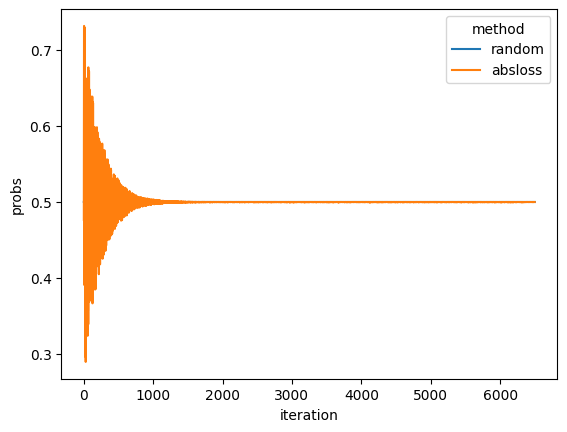

In [91]:
sns.lineplot(
    data=plot1_df, 
    x="iteration", 
    y="probs", 
    hue="method",
)

<Axes: xlabel='iteration', ylabel='train_accuracy'>

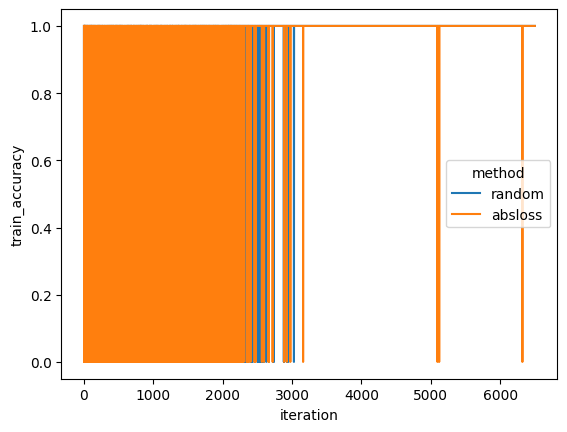

In [92]:
sns.lineplot(
    data=plot1_df, 
    x="iteration", 
    y="train_accuracy", 
    hue="method",
)

<Axes: xlabel='iteration', ylabel='train_loss'>

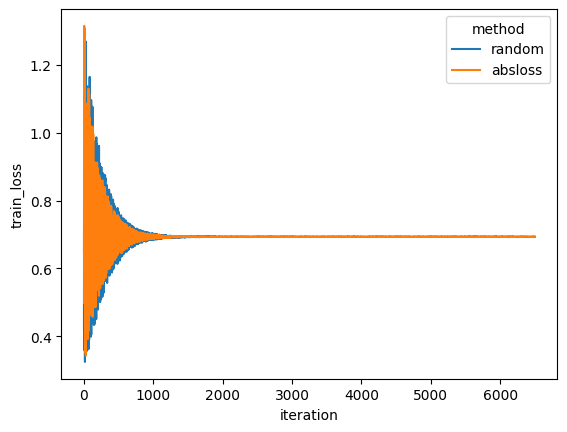

In [52]:
sns.lineplot(
    data=plot1_df, 
    x="iteration", 
    y="train_loss", 
    hue="method",
)

<Axes: xlabel='iteration', ylabel='test_accuracy'>

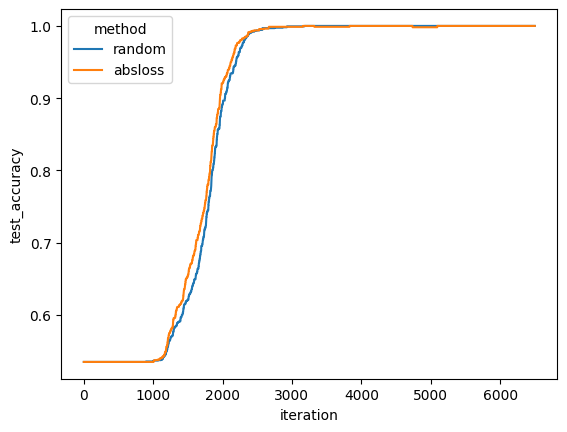

In [57]:
sns.lineplot(
    data=plot1_df, 
    x="iteration", 
    y="test_accuracy", 
    hue="method",
)

In [99]:
np.repeat(np.array([0.5,0.5,0.5,0.5]), 10)

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5])

In [103]:
list(range(1, 3000, 250))

[1, 501, 1001, 1501, 2001, 2501, 3001, 3501, 4001, 4501, 5001, 5501]

<Axes: xlabel='iteration', ylabel='test_loss'>

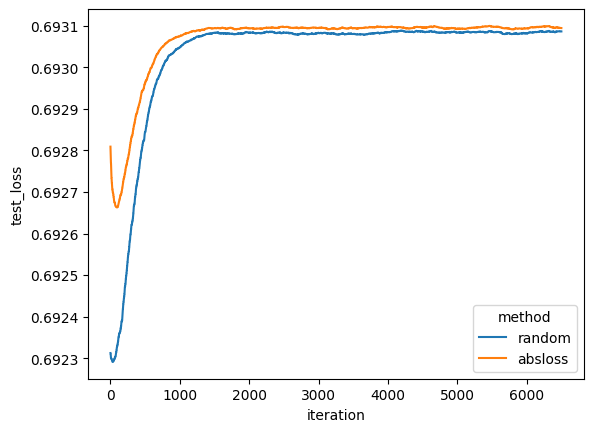

In [54]:
sns.lineplot(
    data=plot1_df, 
    x="iteration", 
    y="test_loss", 
    hue="method",
)

In [107]:
cross_entropy(
    p=np.array([0.5, 0.5]), 
    y=np.array([0,   1])
)

0.6931471805599453

In [71]:
prob_multiplier = [d_prob / np.mean(results_bec_absloss["probs"]) for d_prob in d_probs]

In [72]:
prob_multiplier

[1.999818208350872,
 1.6544164175277183,
 1.3686712477942502,
 1.132279010708793,
 0.9367156358094334,
 0.7749293010568196,
 0.6410861511001619,
 0.5303599342184182,
 0.43875797245262604,
 0.3629771895843448]

In [73]:
# Run this cell only if ~/workspace/milan_paper/polyak_becs_uniform.csv doesn't yet exist
bec_absloss_params = hyperparam_per_algo["bec-absloss"]

becs_absloss_results = {
    f"bec-absloss_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="bec-absloss", verbose=True, **(bec_absloss_params | {"prob_const": prob_multiplier})
    )
    for polyak_str, prob_multiplier in zip(polyak_strs, prob_multiplier)
}

Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.6927986005945063 theta: [0.82155499 0.91985277 0.65958645 ... 0.03509351 0.33950892 0.40905163]
loss: 0.6927072410559344 theta: [0.34904354 0.37236847 0.26339178 ... 0.01491257 0.14423515 0.17377297]
loss: 0.6928861669308904 theta: [0.14697915 0.15678009 0.1105949  ... 0.00627938 0.06073434 0.07316349]
loss: 0.6929976672531151 theta: [0.06246492 0.06660813 0.04697474 ... 0.0026678  0.0258029  0.03106582]
loss: 0.6930513183883765 theta: [0.02584882 0.02755116 0.01942312 ... 0.00110364 0.01041016 0.0120513 ]
loss: 0.6930778100223909 theta: [0.01059721 0.01128135 0.00795288 ... 0.00046755 0.00426781 0.004927  ]
loss: 0.6930892386596671 theta: [0.00434477 0.0046248  0.00326012 ... 0.00019177 0.00174965 0.00201448]
loss: 0.6930916595982277 theta: [2.31450513e-03 1.49740596e-03 1.33642070e-03 ... 8.57439757e-05
 7.12280664e-04 8.25373453e-04]
loss: 0.693094871510341 theta: [0.0009546  0.00061336 0.00052834 ... 0.0013025

loss: 0.6930968457456872 theta: [ 1.27292736e-05 -2.83751443e-05 -6.61435104e-06 ...  5.69916118e-06
 -1.72236876e-07 -8.26445482e-06]
loss: 0.6930954026834493 theta: [ 5.22567729e-06 -1.18915906e-05 -1.08552222e-05 ...  2.45146503e-06
 -4.30725136e-06 -1.81804785e-05]
Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.6924794228617271 theta: [0.23383042 0.86569208 0.03294257 ... 0.48322215 0.18319526 0.64093312]
loss: 0.6925454399743447 theta: [0.11056674 0.38904992 0.00118129 ... 0.22848328 0.08661366 0.30303837]
loss: 0.6927743597978708 theta: [0.05322537 0.18724763 0.00025332 ... 0.10997826 0.04169044 0.14586449]
loss: 0.692917122619017 theta: [0.0272822  0.09593475 0.00012275 ... 0.05634651 0.0213596  0.07471508]
loss: 0.6930056514903449 theta: [1.29116678e-02 4.53606382e-02 5.04566556e-05 ... 2.66425988e-02
 9.80225962e-03 3.44919118e-02]
loss: 0.6930530346977106 theta: [6.21500969e-03 2.18195691e-02 1.32000227e-05 ... 1.28395279e-02
 4.71822749e-03 1.659280

loss: 0.6930943401394095 theta: [ 8.48396538e-06 -5.43988641e-06 -6.69087476e-05 ...  9.77944442e-07
 -3.14534715e-06 -1.97146897e-05]
loss: 0.6930966743792423 theta: [ 4.11499336e-06 -8.11548168e-06 -3.13136209e-05 ...  5.50267905e-07
 -1.63458761e-06 -9.16616115e-06]
loss: 0.6930986538411935 theta: [ 8.04785470e-06 -1.79807364e-05 -2.37000642e-05 ...  2.60184583e-07
 -7.72917613e-07 -1.17224306e-05]
loss: 0.6930974722410709 theta: [ 1.47652137e-05 -8.58085281e-06 -1.13091612e-05 ...  3.32410551e-07
 -3.71873147e-07 -5.60566287e-06]
loss: 0.6930961901449372 theta: [ 7.37333269e-06 -4.40211660e-06 -5.76657251e-06 ...  2.96044029e-07
 -5.29406183e-06 -1.12002638e-05]
Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.692736148003411 theta: [0.89981961 0.54349792 0.92483996 ... 0.47821686 0.6010252  0.86618429]
loss: 0.6926330525439088 theta: [0.50401828 0.28294406 0.49408096 ... 0.26786505 0.33664964 0.48516085]
loss: 0.6927702765143295 theta: [0.26761039 0.1502186

loss: 0.693094008962622 theta: [ 7.97051552e-07 -2.30882084e-04 -3.79316068e-06 ...  2.56075138e-04
 -6.98634106e-06 -3.60815017e-05]
loss: 0.693092950123718 theta: [ 6.18295685e-06 -1.35486867e-04 -7.76902086e-06 ...  1.43434256e-04
 -3.91311905e-06 -2.03421341e-05]
loss: 0.6930965578925867 theta: [ 3.40259915e-06 -7.69781017e-05 -4.17618386e-06 ...  7.49182936e-05
 -2.21529313e-06 -1.09310897e-05]
loss: 0.6930990643240726 theta: [ 1.85767896e-06 -5.67650995e-05 -1.13282653e-05 ...  4.08559913e-05
 -1.20994338e-06 -1.36788378e-05]
loss: 0.6930986105691861 theta: [ 1.44022517e-06 -3.15135418e-05 -6.28892628e-06 ...  2.29071478e-05
 -6.74843821e-07 -7.60474075e-06]
loss: 0.6930969399779223 theta: [ 7.78241612e-07 -1.71706511e-05 -1.21997473e-05 ...  1.24025752e-05
 -5.89192724e-06 -2.02158175e-05]
Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.6929947235395567 theta: [0.19750494 0.89797641 0.41062075 ... 0.88715099 0.23151702 0.7270539 ]
loss: 0.692781344086069

loss: 0.6930950903723273 theta: [ 2.15429005e-05 -7.19395889e-04 -2.04558237e-04 ...  2.88404516e-04
 -2.25051655e-06 -6.22672743e-05]
loss: 0.6930959875844386 theta: [ 1.96396120e-05 -4.48578261e-04 -1.33965104e-04 ...  1.79791280e-04
 -1.40293544e-06 -3.90843682e-05]
loss: 0.6930958265993389 theta: [ 1.19249898e-05 -2.78821854e-04 -8.15841914e-05 ...  1.09123404e-04
 -1.02855472e-06 -2.40584278e-05]
loss: 0.6930982903316234 theta: [ 1.39596475e-05 -1.72619014e-04 -4.83850230e-05 ...  6.44820090e-05
 -6.07743516e-07 -1.45008615e-05]
loss: 0.6930957339679698 theta: [ 1.50573225e-05 -1.06652824e-04 -2.98947055e-05 ...  3.99564939e-05
 -3.78690660e-07 -1.54000949e-05]
loss: 0.6930948923099638 theta: [ 9.56042086e-06 -6.79816453e-05 -2.75455647e-05 ...  2.54975046e-05
 -2.43267964e-07 -1.00874122e-05]
Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.6921217896959294 theta: [0.02744769 0.3423395  0.39271336 ... 0.8418823  0.85458219 0.91559073]
loss: 0.6922533701059

loss: 0.6930917190063592 theta: [ 6.65061118e-05 -2.54707828e-06 -7.62039271e-05 ...  5.01754994e-04
 -3.60259489e-06 -7.11091757e-05]
loss: 0.693092294132977 theta: [ 4.33490974e-05 -1.94282702e-06 -4.98315422e-05 ...  3.27047026e-04
 -2.51067432e-06 -4.64801692e-05]
loss: 0.6930939490710382 theta: [ 2.66609487e-05 -7.85907883e-06 -3.69202835e-05 ...  2.00274430e-04
 -1.53745029e-06 -2.84650794e-05]
loss: 0.693097097388115 theta: [ 1.80286802e-05 -1.23658781e-05 -2.48557606e-05 ...  1.34079258e-04
 -1.02919545e-06 -1.93876571e-05]
loss: 0.6930970677283258 theta: [ 2.05634393e-05 -1.71642597e-05 -2.67514333e-05 ...  9.46962716e-05
 -7.29183211e-07 -2.20303899e-05]
loss: 0.6930978550304403 theta: [ 1.95016832e-05 -1.08925566e-05 -1.69764942e-05 ...  6.02408666e-05
 -4.62739121e-07 -2.05397143e-05]
loss: 0.6930965936512475 theta: [ 1.26007609e-05 -7.20527386e-06 -2.00439045e-05 ...  3.90602225e-05
 -3.01969997e-07 -2.23048642e-05]
Training with algorithm bec-absloss: 6499 iterations with

loss: 0.6930954396119234 theta: [ 1.41510695e-06 -3.74385332e-04 -5.35966291e-06 ...  1.12811908e-05
 -9.39534746e-06 -1.28884244e-04]
loss: 0.6930976099666556 theta: [ 9.90628094e-07 -2.62212504e-04 -3.88731490e-06 ...  7.90165348e-06
 -6.57664239e-06 -9.02219108e-05]
loss: 0.6930976189376248 theta: [ 7.02150652e-07 -1.85193099e-04 -2.88520636e-06 ...  5.58365676e-06
 -4.64479913e-06 -6.38879624e-05]
loss: 0.6930973773757364 theta: [ 8.31213667e-06 -1.44086388e-04 -1.98410764e-06 ...  3.83947993e-06
 -3.19384855e-06 -5.28254491e-05]
loss: 0.6930962847447925 theta: [ 1.34005676e-05 -9.90779685e-05 -1.36433027e-06 ...  2.64576393e-06
 -2.19934713e-06 -4.31833963e-05]
loss: 0.6930949457138932 theta: [ 9.46915779e-06 -6.99785173e-05 -1.11055664e-06 ...  1.86862594e-06
 -1.55577955e-06 -3.05073740e-05]
Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.6926255961900236 theta: [0.05069927 0.92838862 0.93498438 ... 0.67087033 0.09957054 0.07568649]
loss: 0.6925416240648

loss: 0.6930947095106802 theta: [ 1.91251048e-07 -3.05989386e-05 -9.49867679e-06 ...  3.65821689e-04
 -3.11092830e-06 -2.51464908e-05]
loss: 0.6930940729694793 theta: [ 1.47908419e-07 -2.32116620e-05 -7.34885494e-06 ...  2.77473162e-04
 -2.35956006e-06 -1.90794059e-05]
loss: 0.6930959222755868 theta: [ 2.80316028e-07 -1.69685019e-05 -5.44284935e-06 ...  1.99633357e-04
 -1.86932785e-06 -1.40478416e-05]
loss: 0.6930966463664742 theta: [ 2.18383161e-07 -1.32254370e-05 -4.41644437e-06 ...  1.55525725e-04
 -1.45636126e-06 -1.97456140e-05]
loss: 0.693097560255441 theta: [ 8.43077703e-06 -1.04888103e-05 -3.50257193e-06 ...  1.23349430e-04
 -1.15500157e-06 -2.35632182e-05]
loss: 0.6930979140420767 theta: [ 6.17551493e-06 -7.68226437e-06 -2.56903440e-06 ...  9.04412223e-05
 -8.47945746e-07 -1.74116768e-05]
Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.6928607022388016 theta: [0.66613347 0.67043462 0.64614833 ... 0.99776599 0.87198628 0.47549954]
loss: 0.69273967711967

loss: 0.6930961569998527 theta: [ 9.48732489e-06 -2.59510733e-05 -7.32385403e-06 ...  1.11187955e-06
 -4.89198330e-06 -2.51452043e-05]
loss: 0.6930956907893369 theta: [ 7.52678681e-06 -2.05867656e-05 -5.81427082e-06 ...  8.84675513e-07
 -3.87976658e-06 -2.92244628e-05]
Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.6927878314671218 theta: [0.64337272 0.1139918  0.86858577 ... 0.65440085 0.06442748 0.27971483]
loss: 0.6926697924156858 theta: [0.50571321 0.06433356 0.6827383  ... 0.51438185 0.05064223 0.21986552]
loss: 0.6926496637950961 theta: [0.43847395 0.05577982 0.59196169 ... 0.44599002 0.04390887 0.19063217]
loss: 0.6926491270972457 theta: [0.38017477 0.04836337 0.51324413 ... 0.38669151 0.03807078 0.1652753 ]
loss: 0.6926689370900234 theta: [0.32092634 0.04082615 0.4332573  ... 0.32642751 0.03160541 0.13951788]
loss: 0.6926942163100615 theta: [0.27825621 0.03539793 0.37565173 ... 0.28303403 0.02740318 0.12096751]
loss: 0.6927497229484687 theta: [0.214853

loss: 0.6920140331693281 theta: [0.54099604 0.46044457 0.1388634  ... 0.28712503 0.63153136 0.57008781]
loss: 0.6920978703709662 theta: [0.46490161 0.3956802  0.1193314  ... 0.24673913 0.54270259 0.48989139]
loss: 0.6922070001671258 theta: [0.385512   0.32811088 0.09894337 ... 0.20460436 0.45002717 0.405148  ]
loss: 0.6922819619896671 theta: [0.34026906 0.28959376 0.08733118 ... 0.18059239 0.39721286 0.35760062]
loss: 0.6924148265558902 theta: [0.26985884 0.22966953 0.06926016 ... 0.14322328 0.31501953 0.28360406]
loss: 0.6925243727254691 theta: [0.21786923 0.18542259 0.05591686 ... 0.11563063 0.2543295  0.22896636]
loss: 0.6925930716110381 theta: [0.18722458 0.15934176 0.04805181 ... 0.09983105 0.21855629 0.19676067]
loss: 0.6926683576091061 theta: [0.15526115 0.13213099 0.03983599 ... 0.08322756 0.1812342  0.16316053]
loss: 0.6927220471589773 theta: [0.13342271 0.11353615 0.03423281 ... 0.07152109 0.15574249 0.14021099]
loss: 0.6927731015758902 theta: [0.11363816 0.0966919  0.0291566

In [45]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
becs_absloss_results_file = os.path.join(notebook_dir, "bec_absloss_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(becs_absloss_results_file, "wb") as f:
    pickle.dump(becs_absloss_results, f)

In [29]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
becs_absloss_results_file = os.path.join(notebook_dir, "bec_absloss_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(becs_absloss_results_file, "rb") as f:
    becs_absloss_results = pickle.load(f)
    
for k in becs_absloss_results.keys():
    del becs_absloss_results[k]["thetas"]

## Plot Polyak-bec results

In [74]:
import re
df_test_losses = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in polyak_becs2.items()]
)
df_test_losses.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses = df_test_losses.explode(["test_loss", "test_accuracy"])
df_test_losses["iteration"] = df_test_losses.groupby('polyak_exp').cumcount()+1
df_test_losses = df_test_losses.reset_index()

In [75]:
df_test_losses["cost"] = [np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses.iteration, df_test_losses.labeled)]

(0.0, 6823.95)

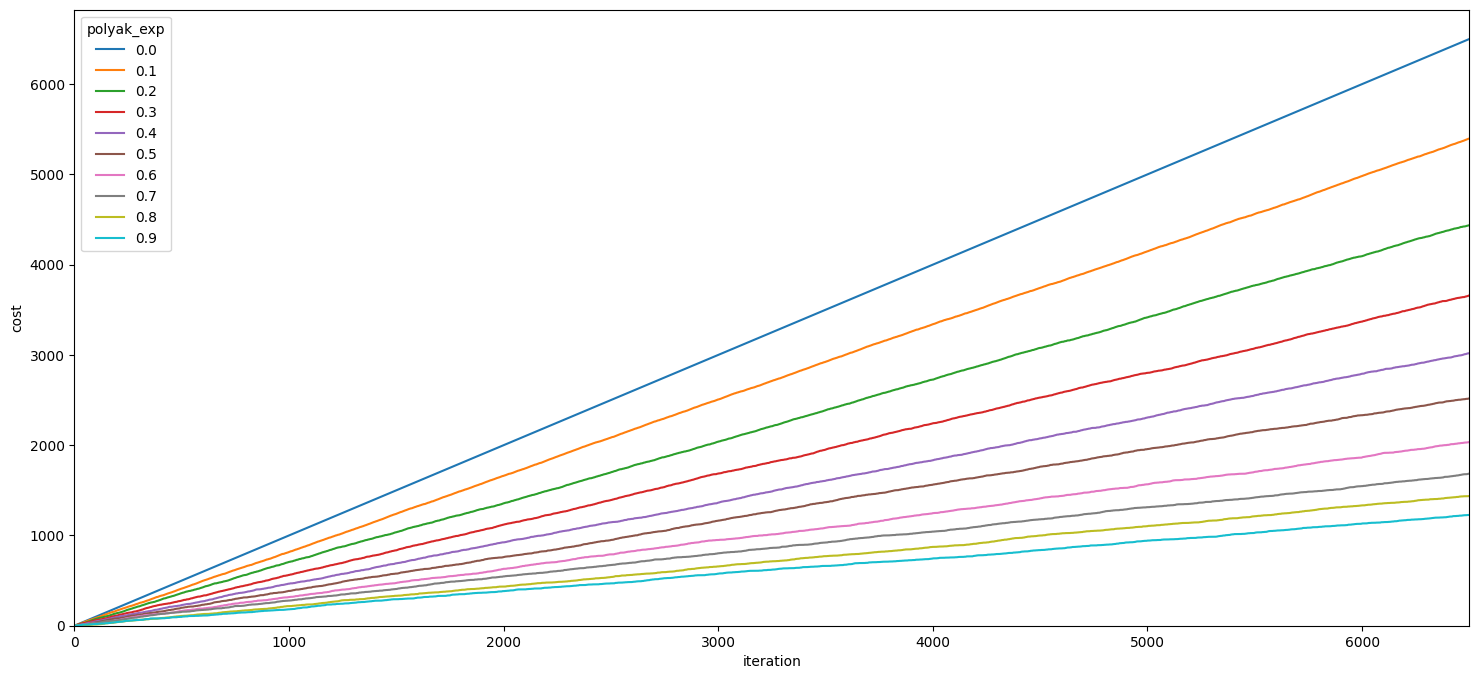

In [76]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="iteration", y="cost", hue="polyak_exp")
ax.set_xlim((0, 6500))
ax.set_ylim(bottom=0)

(0.0, 0.6932102750641616)

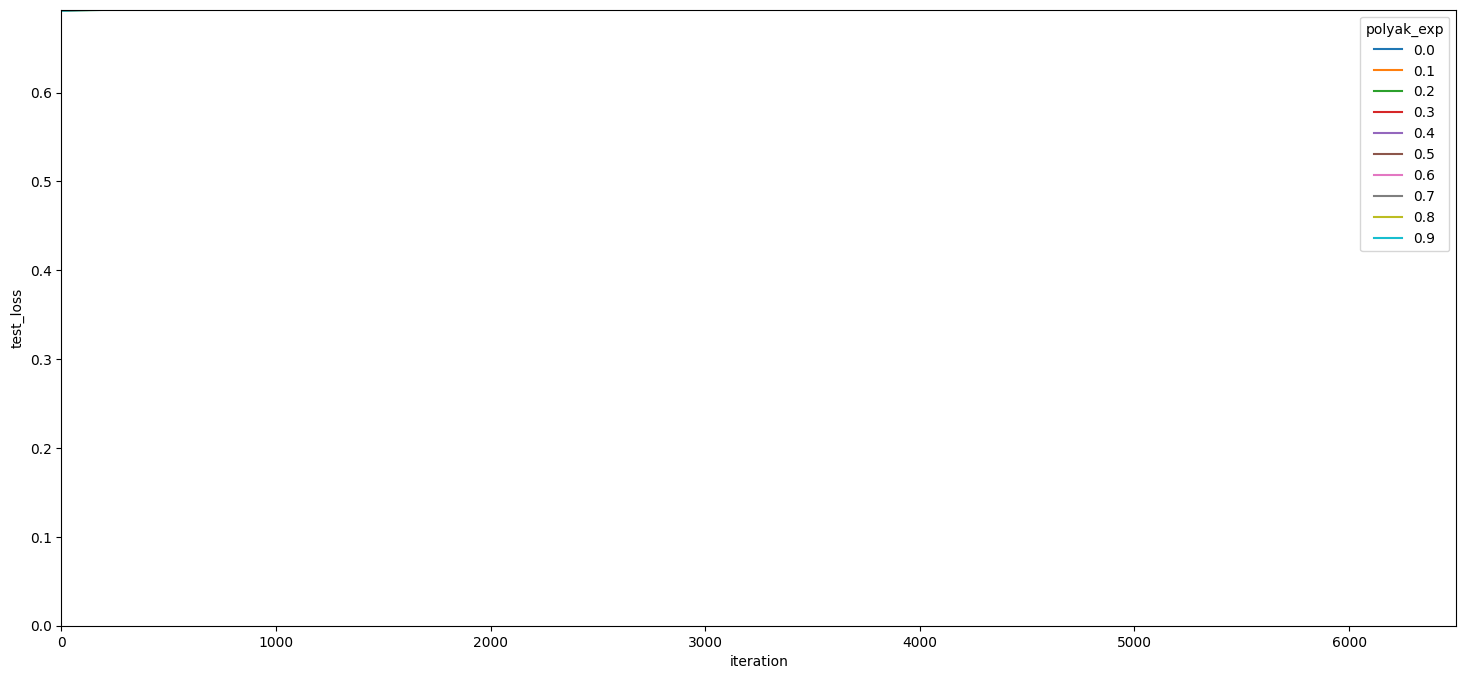

In [77]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="iteration", y="test_loss", hue="polyak_exp")
ax.set_xlim((0, 6500))
ax.set_ylim(bottom=0)

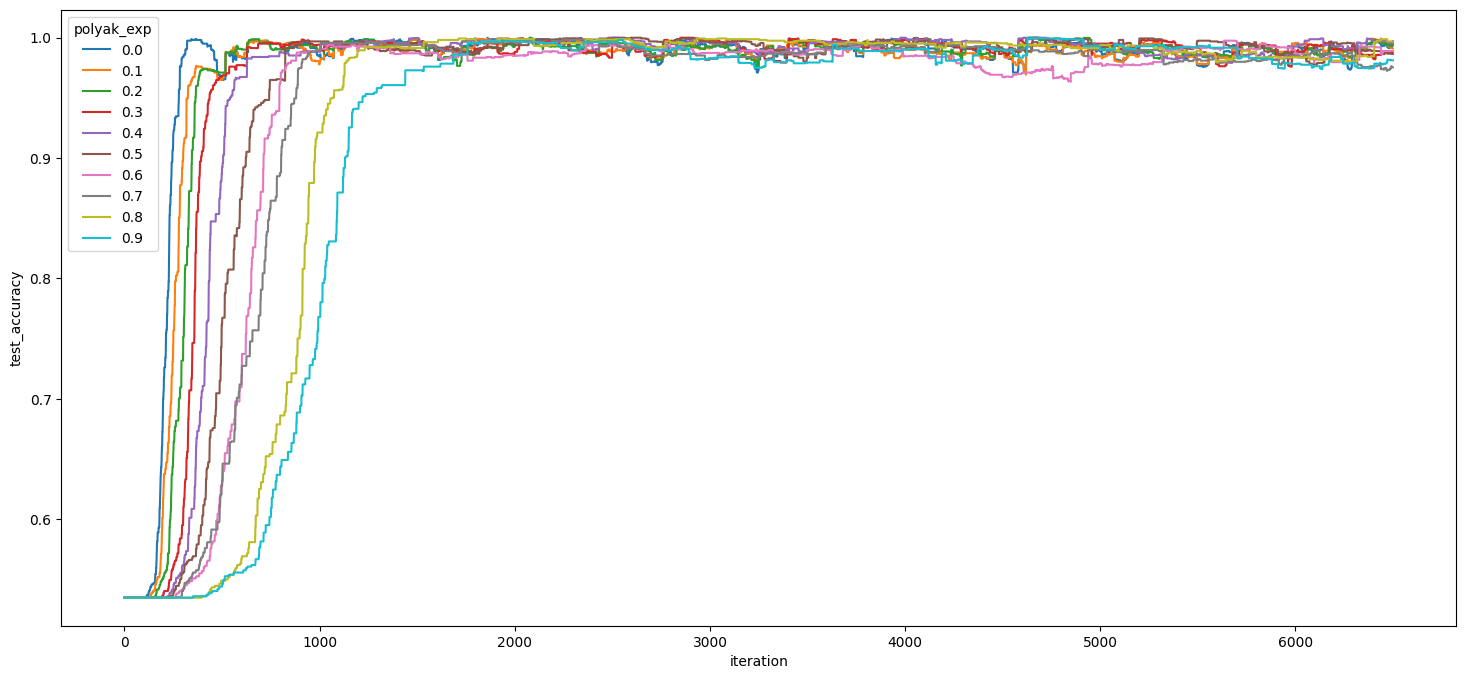

In [78]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="iteration", y="test_accuracy", hue="polyak_exp")

In [ ]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="cost", y="test_accuracy", hue="polyak_exp")
ax.set_xlim((0, 4000))

In [ ]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="cost", y="test_loss", hue="polyak_exp")
ax.set_xlim((0, 1000))
ax.set_ylim(bottom=0)

## Make comparison plots

In [79]:
df_test_losses["method"] = "polyak_absloss"

import re
df_test_losses_rand = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in rand_results.items()]
)


df_test_losses_rand.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses_rand = df_test_losses_rand.explode(["test_loss", "test_accuracy"])
df_test_losses_rand["iteration"] = df_test_losses_rand.groupby('polyak_exp').cumcount()+1
df_test_losses_rand = df_test_losses_rand.reset_index()
df_test_losses_rand["cost"] = [
    np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses_rand.iteration, df_test_losses_rand.labeled)
]
df_test_losses_rand["method"] = "rand"


import re
df_test_losses_bec_absloss = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in becs_absloss_results.items()]
)


df_test_losses_bec_absloss.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses_bec_absloss = df_test_losses_bec_absloss.explode(["test_loss", "test_accuracy"])
df_test_losses_bec_absloss["iteration"] = df_test_losses_bec_absloss.groupby('polyak_exp').cumcount()+1
df_test_losses_bec_absloss = df_test_losses_bec_absloss.reset_index()
df_test_losses_bec_absloss["cost"] = [
    np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses_bec_absloss.iteration, df_test_losses_bec_absloss.labeled)
]
df_test_losses_bec_absloss["method"] = "absloss"


import re
df_test_losses_polyak_rand = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in polyak_rand_results.items()]
)
df_test_losses_polyak_rand.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses_polyak_rand = df_test_losses_polyak_rand.explode(["test_loss", "test_accuracy"])
df_test_losses_polyak_rand["iteration"] = df_test_losses_polyak_rand.groupby('polyak_exp').cumcount()+1
df_test_losses_polyak_rand = df_test_losses_polyak_rand.reset_index()
df_test_losses_polyak_rand["cost"] = [
    np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses_polyak_rand.iteration, df_test_losses_polyak_rand.labeled)
]
df_test_losses_polyak_rand["method"] = "polyak_rand"

In [80]:
df_test_losses_rand

,index,polyak_exp,labeled,test_loss,test_accuracy,iteration,cost,method
0,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.692272,0.534769,1,1.0,rand
1,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.69227,0.534769,2,2.0,rand
2,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.692268,0.534769,3,3.0,rand
3,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.692266,0.534769,4,4.0,rand
4,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.692264,0.534769,5,5.0,rand
...,...,...,...,...,...,...,...,...
64985,9,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0.693085,0.967385,6495,1134.0,rand
64986,9,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0.693085,0.967385,6496,1134.0,rand
64987,9,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0.693085,0.967385,6497,1134.0,rand
64988,9,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0.693085,0.969846,6498,1135.0,rand


In [81]:
df_test_losses

,index,polyak_exp,labeled,test_loss,test_accuracy,iteration,cost,method
0,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.691866,0.534769,1,1.0,polyak_absloss
1,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.691888,0.534769,2,2.0,polyak_absloss
2,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.691914,0.534769,3,3.0,polyak_absloss
3,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.691945,0.534769,4,4.0,polyak_absloss
4,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.691978,0.534769,5,5.0,polyak_absloss
...,...,...,...,...,...,...,...,...
64985,9,0.9,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",0.693139,0.981231,6495,1227.0,polyak_absloss
64986,9,0.9,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",0.693139,0.981231,6496,1227.0,polyak_absloss
64987,9,0.9,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",0.693139,0.981231,6497,1227.0,polyak_absloss
64988,9,0.9,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",0.693139,0.981231,6498,1227.0,polyak_absloss


In [82]:
df_test_losses_polyak_rand

,index,polyak_exp,labeled,test_loss,test_accuracy,iteration,cost,method
0,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.691856,0.534769,1,1.0,polyak_rand
1,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.691868,0.534769,2,2.0,polyak_rand
2,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.691879,0.534769,3,3.0,polyak_rand
3,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.691896,0.534769,4,4.0,polyak_rand
4,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.691912,0.534769,5,5.0,polyak_rand
...,...,...,...,...,...,...,...,...
64985,9,0.9,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.693114,0.998769,6495,1150.0,polyak_rand
64986,9,0.9,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.693114,0.998769,6496,1150.0,polyak_rand
64987,9,0.9,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.693114,0.998769,6497,1151.0,polyak_rand
64988,9,0.9,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.69311,0.998769,6498,1152.0,polyak_rand


In [83]:
df_test_losses_bec_absloss[df_test_losses_bec_absloss.iteration == 6499]

,index,polyak_exp,labeled,test_loss,test_accuracy,iteration,cost,method
6498,0,0.0,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.693094,1.0,6499,6486.0,absloss
12997,1,0.1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",0.693094,1.0,6499,5382.0,absloss
19496,2,0.2,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...",0.693094,1.0,6499,4409.0,absloss
25995,3,0.3,"[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",0.693093,1.0,6499,3700.0,absloss
32494,4,0.4,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.693097,0.998154,6499,3012.0,absloss
38993,5,0.5,"[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...",0.693095,1.0,6499,2509.0,absloss
45492,6,0.6,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",0.693097,1.0,6499,2015.0,absloss
51991,7,0.7,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0.693095,1.0,6499,1699.0,absloss
58490,8,0.8,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",0.693096,1.0,6499,1383.0,absloss
64989,9,0.9,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",0.693093,0.996308,6499,1268.0,absloss


In [84]:
df_test_losses = pd.concat([df_test_losses_rand, df_test_losses_bec_absloss, df_test_losses, df_test_losses_polyak_rand])

/var/folders/s7/8k0y__9d35n2x08wq1cqf9j00000gn/T/ipykernel_6943/981126154.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot2["method"] = ["polyak_exponent" if method == "polyak_absloss" else method for method in df_plot2.method]


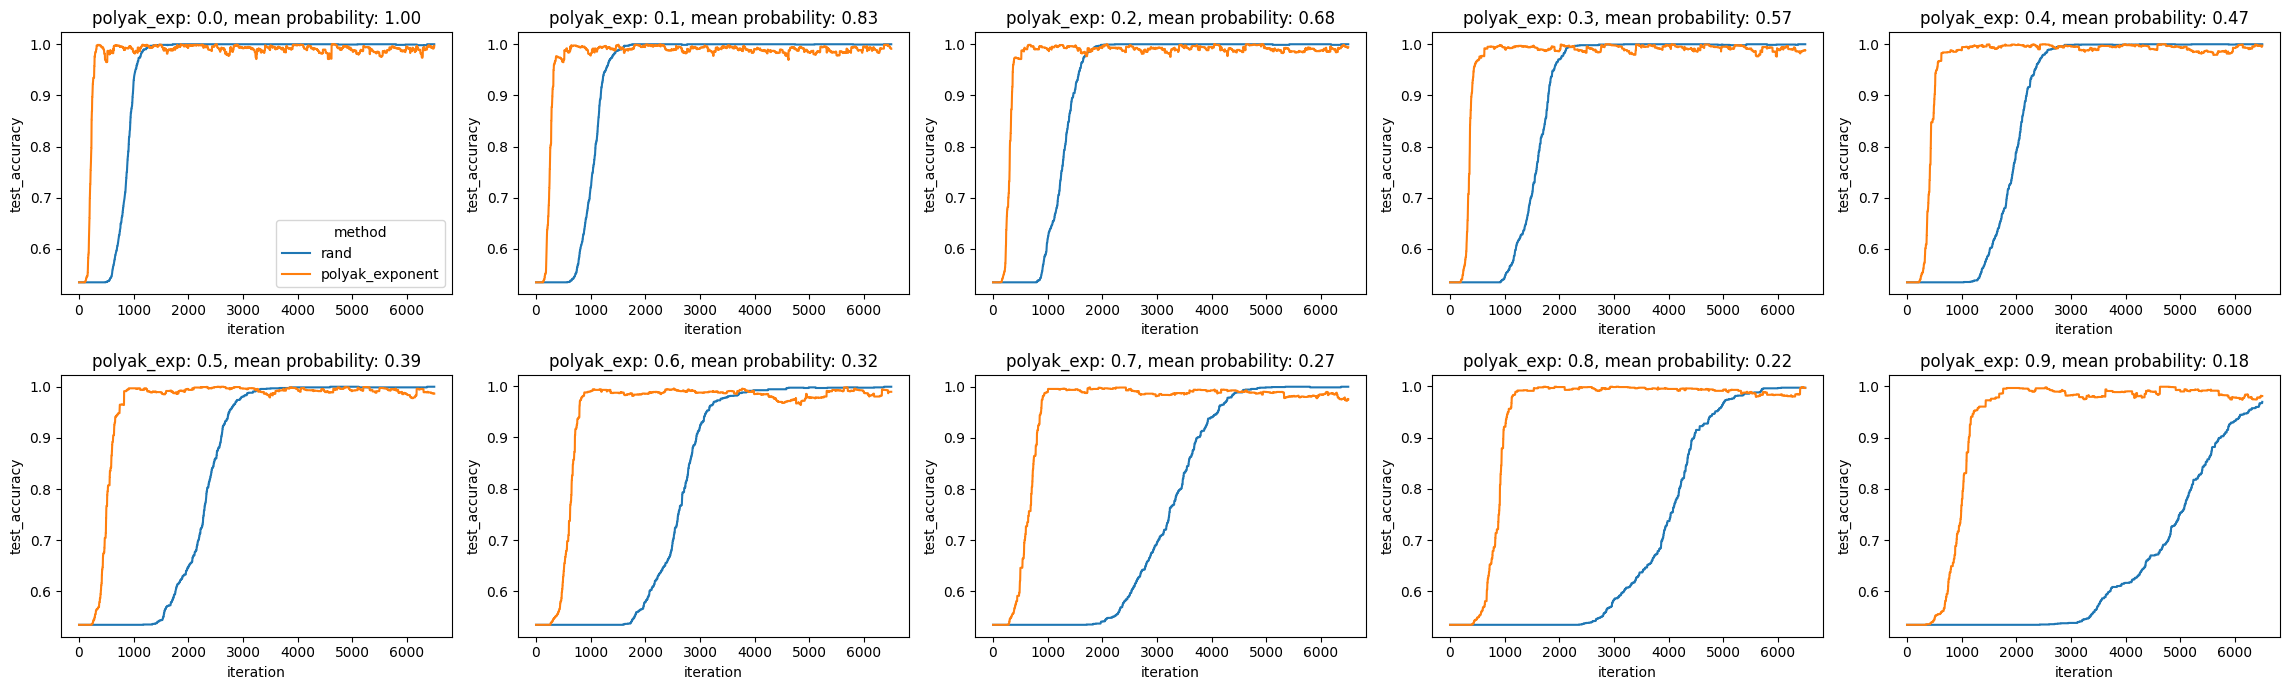

In [150]:
f, axs = plt.subplots(2, 5, figsize=(23, 7))
handles, labels = [], []

df_plot2 = df_test_losses[df_test_losses.method.isin(["rand", "polyak_absloss"])]
df_plot2["method"] = ["polyak_exponent" if method == "polyak_absloss" else method for method in df_plot2.method]
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_plot2[df_plot2.polyak_exp == polyak_exp], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        #legend=False,
        ax=ax
    )
    # Display the legend only for the first plot
    #if i == 0:
    #    ax.legend()
    
    ax.set_title(f"polyak_exp: {polyak_exp}, mean probability: {d_probs[i]:.2f}")
    
    # Collect handles and labels for this subplot
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
#axs[0][0].legend()
#f.legend(handles, labels)

f.tight_layout()

/var/folders/s7/8k0y__9d35n2x08wq1cqf9j00000gn/T/ipykernel_6943/3169719096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot2["method"] = ["polyak_exponent" if method == "polyak_absloss" else method for method in df_plot2.method]


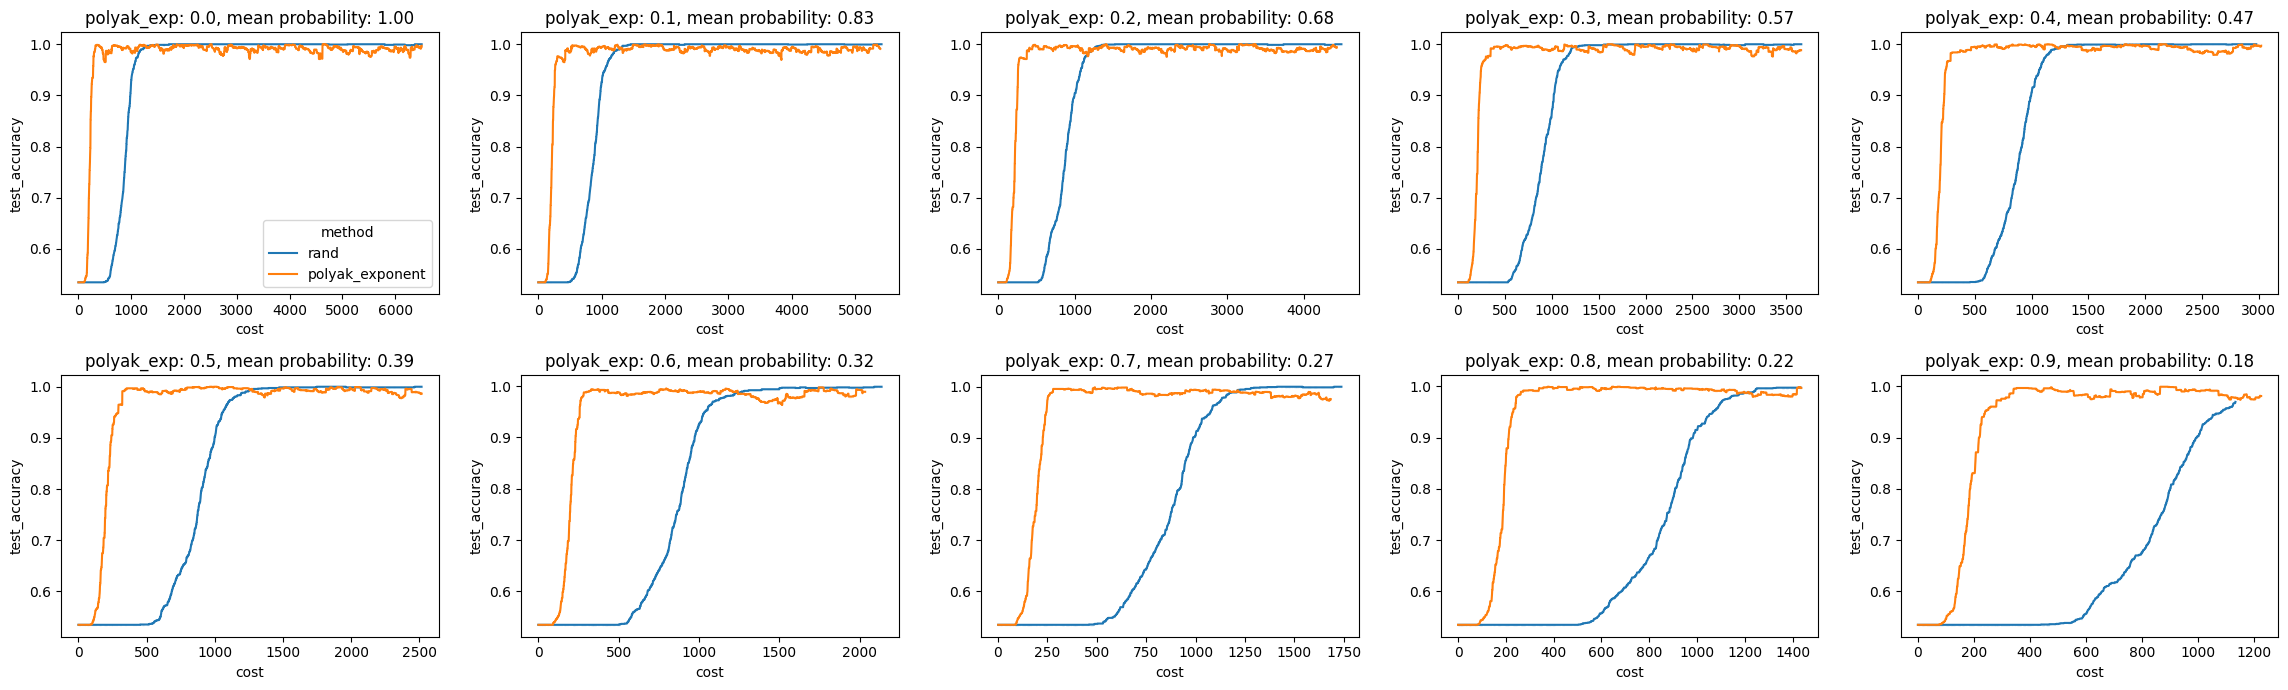

In [151]:
f, axs = plt.subplots(2, 5, figsize=(23, 7))
handles, labels = [], []

df_plot2 = df_test_losses[df_test_losses.method.isin(["rand", "polyak_absloss"])]
df_plot2["method"] = ["polyak_exponent" if method == "polyak_absloss" else method for method in df_plot2.method]
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_plot2[df_plot2.polyak_exp == polyak_exp], 
        x="cost", 
        y="test_accuracy", 
        hue="method",
        #legend=False,
        ax=ax
    )
    # Display the legend only for the first plot
    #if i == 0:
    #    ax.legend()
    
    ax.set_title(f"polyak_exp: {polyak_exp}, mean probability: {d_probs[i]:.2f}")
    
    # Collect handles and labels for this subplot
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
#axs[0][0].legend()
#f.legend(handles, labels)

f.tight_layout()

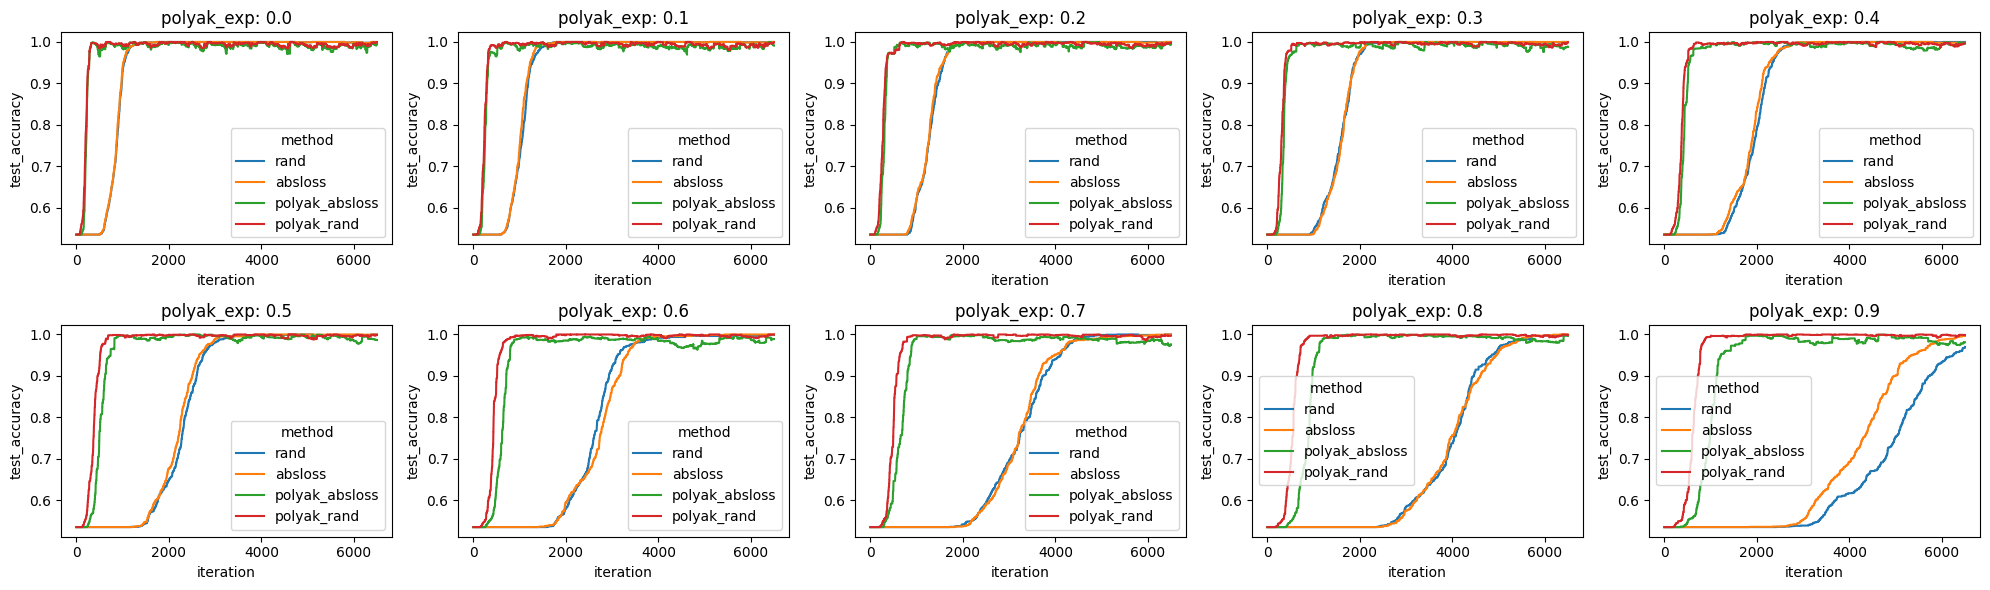

In [137]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))

for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    
f.tight_layout()

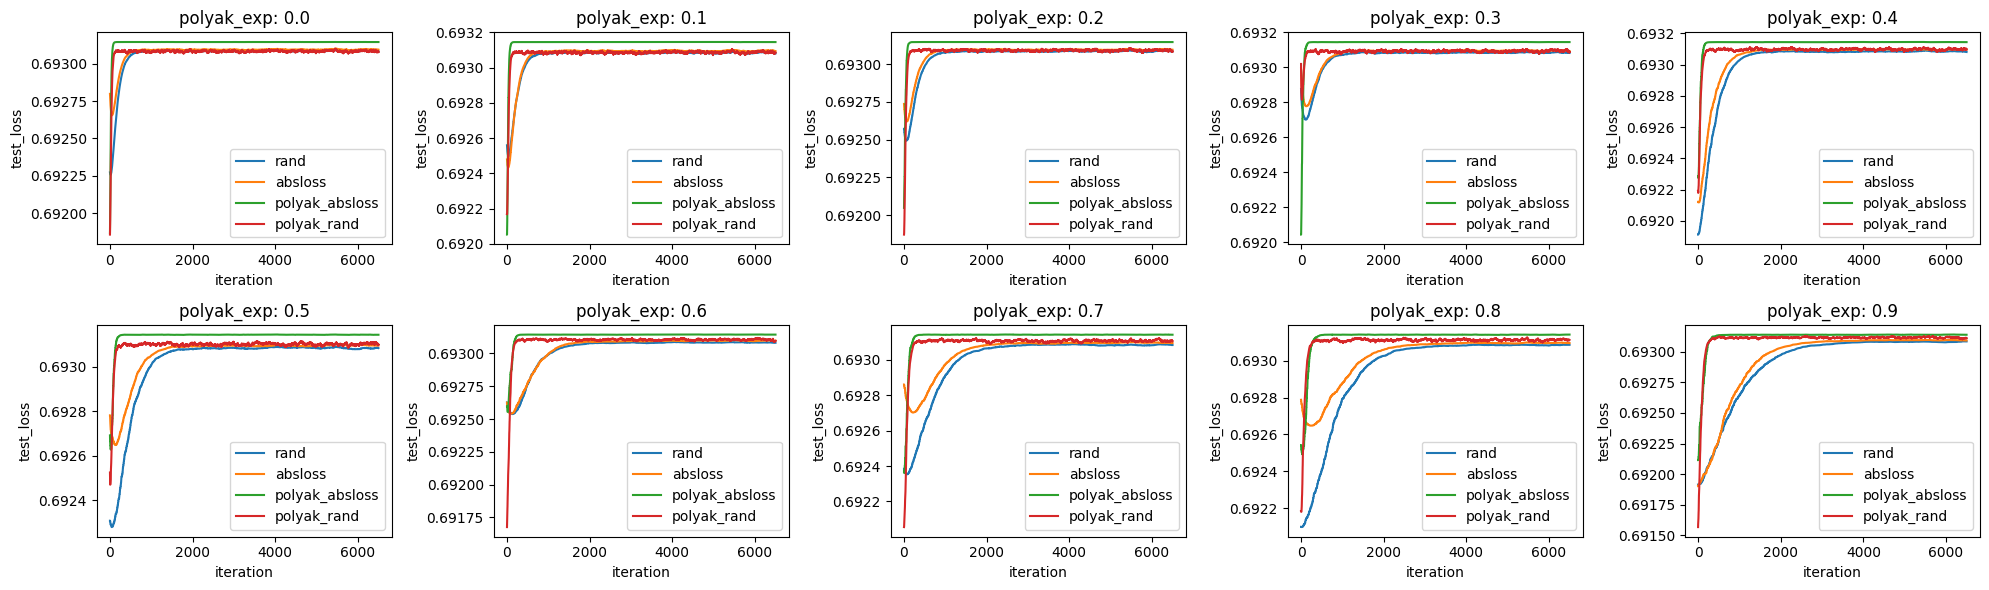

In [90]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

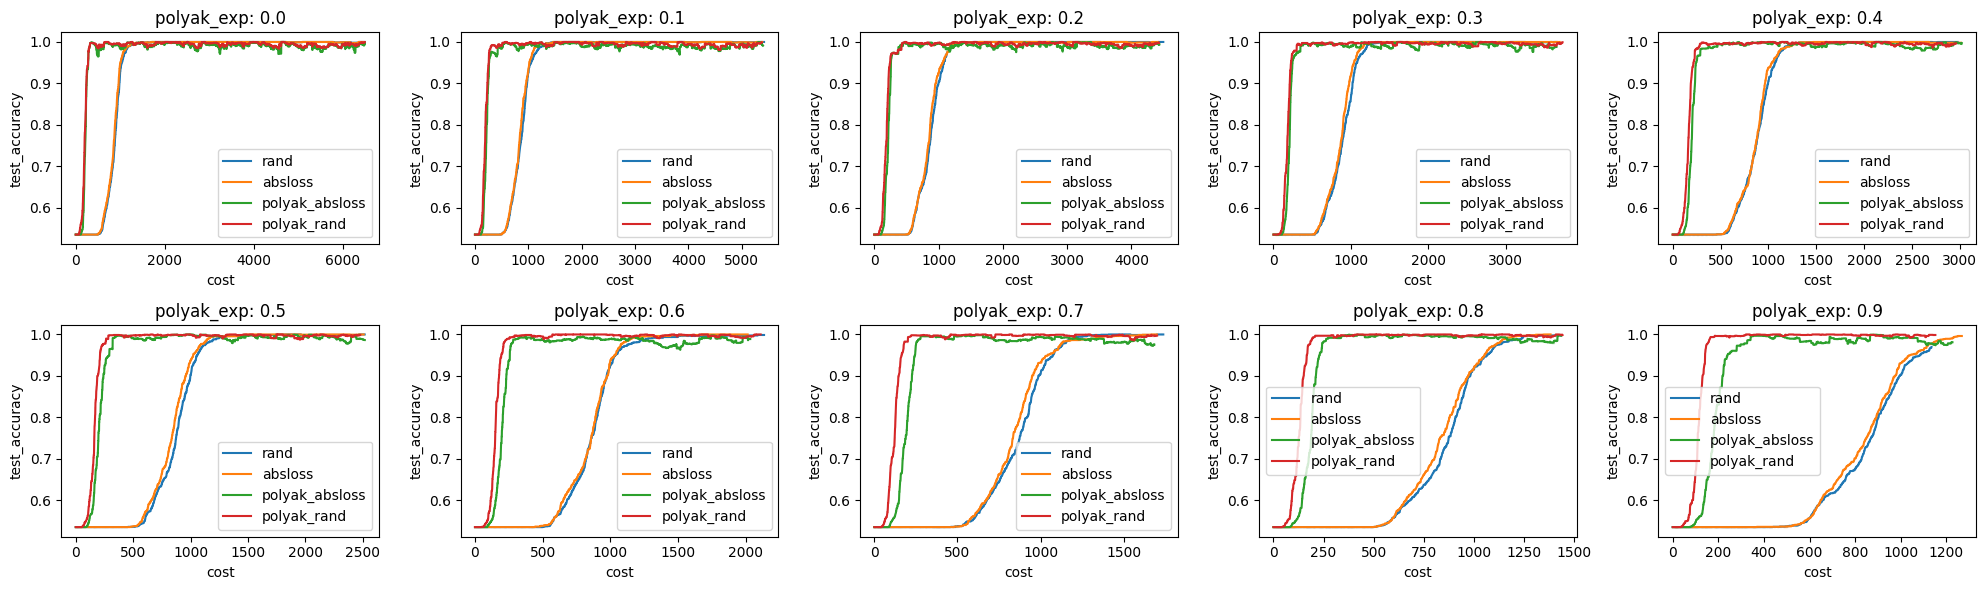

In [88]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="cost", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

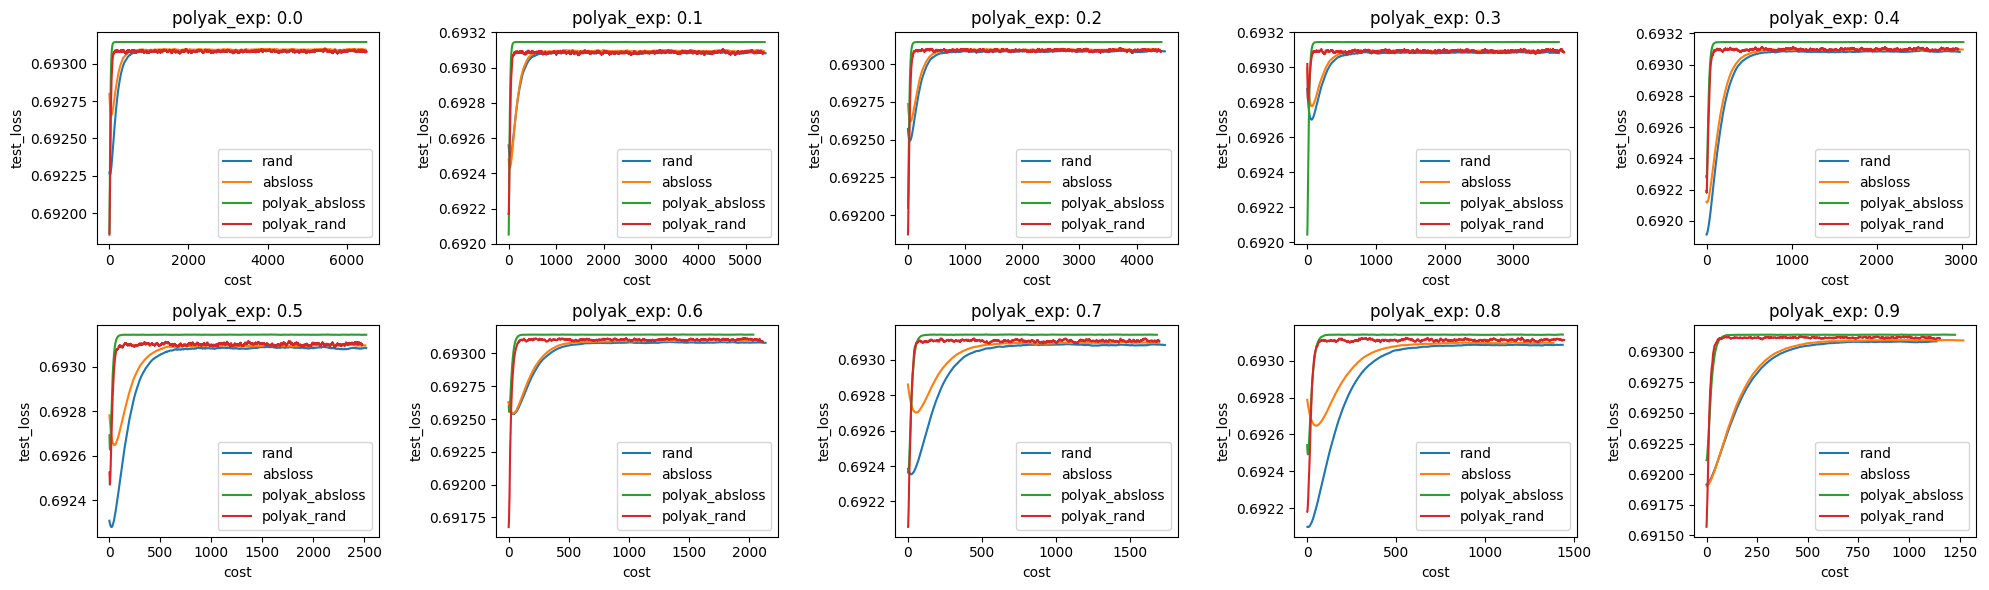

In [89]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="cost", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

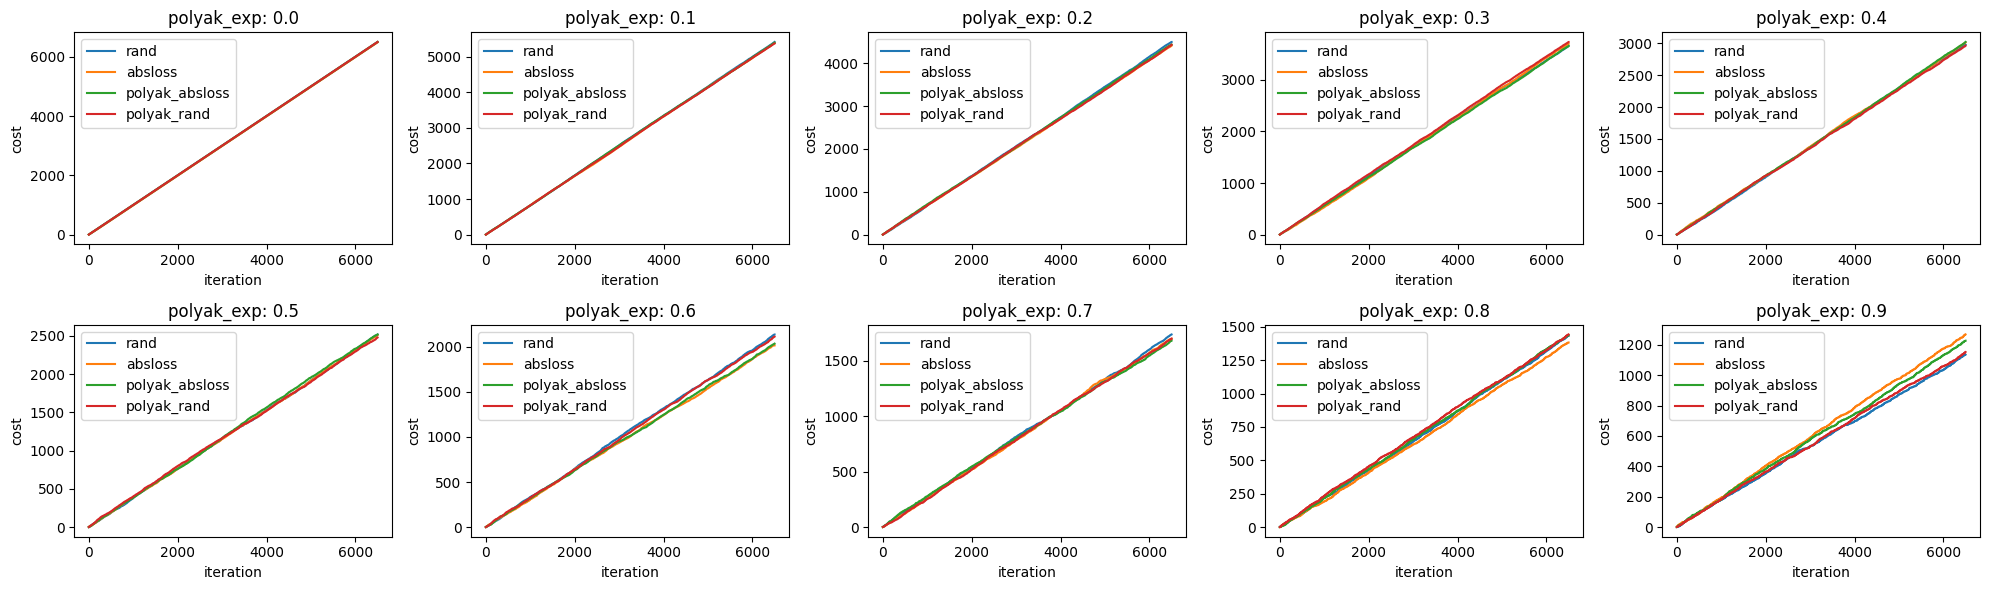

In [87]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="iteration", 
        y="cost", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

In [43]:
for r in rand_results.keys():
    print(f"{r}: {np.mean(rand_results[r]['probs'])}")


rand_0.0: 1.0
rand_0.1: 0.7745240529580661
rand_0.2: 0.5998875086105891
rand_0.3: 0.46462730448799056
rand_0.4: 0.35986502298701983
rand_0.5: 0.27872411612175435
rand_0.6: 0.2158785320757759
rand_0.7: 0.16720311560996784
rand_0.8: 0.1295028347694484
rand_0.9: 0.10030306045519197


In [44]:
for r in polyak_becs2.keys():
    print(f"{r}: {np.mean(polyak_becs2[r]['probs'])}")


polyak_bec_0.0: 1.0
polyak_bec_0.1: 0.7419212721953483
polyak_bec_0.2: 0.5504471741359643
polyak_bec_0.3: 0.408388467711289
polyak_bec_0.4: 0.3029920915142684
polyak_bec_0.5: 0.22479627800139557
polyak_bec_0.6: 0.1667811405595745
polyak_bec_0.7: 0.12373847598215079
polyak_bec_0.8: 0.09180420752019085
polyak_bec_0.9: 0.06811149443626574


In [45]:
for r in polyak_rand_results.keys():
    print(f"{r}: {np.mean(polyak_rand_results[r]['probs'])}")

polyak_rand_0.0: 1.0
polyak_rand_0.1: 0.7745240529580661
polyak_rand_0.2: 0.5998875086105891
polyak_rand_0.3: 0.46462730448799056
polyak_rand_0.4: 0.35986502298701983
polyak_rand_0.5: 0.27872411612175435
polyak_rand_0.6: 0.2158785320757759
polyak_rand_0.7: 0.16720311560996784
polyak_rand_0.8: 0.1295028347694484
polyak_rand_0.9: 0.10030306045519197


In [46]:
for r in becs_absloss_results.keys():
    print(f"{r}: {np.mean(becs_absloss_results[r]['probs'])}")


bec-absloss_0.0: 0.9927062163792975
bec-absloss_0.1: 0.7748089287665765
bec-absloss_0.2: 0.6001138454239615
bec-absloss_0.3: 0.46480860781038985
bec-absloss_0.4: 0.35965045429675674
bec-absloss_0.5: 0.278694930109958
bec-absloss_0.6: 0.21557566129648265
bec-absloss_0.7: 0.166865114612842
bec-absloss_0.8: 0.1294103533801973
bec-absloss_0.9: 0.10002878191273452


In [47]:
2

2